# Analysis of Travel Dataset: Guide to India's Must See Places

In [2]:
#Import libarys
import pandas as pd
import math
import pingouin as pg
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy as sp
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.express as px
import plotly
import plotly.graph_objects as go
from plotly.graph_objs import Scatter, Figure, Histogram, Layout, Bar
plotly.offline.init_notebook_mode(connected = True)
from plotly.subplots import make_subplots
from geopy.geocoders import Nominatim
from pypalettes import load_cmap
from pypalettes import get_hex
from geopy.distance import geodesic

## Introduction

This dataset was downloaded from [Kaggle](https://www.kaggle.com/datasets/saketk511/travel-dataset-guide-to-indias-must-see-places).

The data is loaded into the noteboook, and the head and shape is displayed for initial inspection.

Through the process of the following inspection, it is found that the dataset is completely without NaN values. The na_filter is set to False to avoid filtering string of 'None' in the variable that describes what day an attraction is not open.

In [4]:
#File renamed to 'data.csv' and saved in current working directory
with open('data.csv') as x:
    ncols = len(x.readline().split(','))

df_raw = pd.read_csv('data.csv', usecols=range(1,ncols), na_filter = False)

In [139]:
#Make a copy of the dataset to avoid the need to re-import
df = df_raw.copy()

In [141]:
#display dataframe head for initial inspection
df.head()

Zone  State   City                  Name          Type  \
0  Northern  Delhi  Delhi            India Gate  War Memorial   
1  Northern  Delhi  Delhi        Humayun's Tomb          Tomb   
2  Northern  Delhi  Delhi     Akshardham Temple        Temple   
3  Northern  Delhi  Delhi  Waste to Wonder Park    Theme Park   
4  Northern  Delhi  Delhi         Jantar Mantar   Observatory   

  Establishment Year  time needed to visit in hrs  Google review rating  \
0               1921                          0.5                   4.6   
1               1572                          2.0                   4.5   
2               2005                          5.0                   4.6   
3               2019                          2.0                   4.1   
4               1724                          2.0                   4.2   

   Entrance Fee in INR Airport with 50km Radius Weekly Off   Significance  \
0                    0                      Yes       None     Historical   
1                   30                      Yes       None     Historical   
2                   60                      Yes       None      Religious   
3                   50                      Yes     Monday  Environmental   
4                   15                      Yes       None     Scientific   

  DSLR Allowed  Number of google review in lakhs Best Time to visit  
0          Yes                              2.60            Evening  
1          Yes                              0.40          Afternoon  
2           No                              0.40          Afternoon  
3          Yes                              0.27            Evening  
4          Yes                              0.31            Morning

In [7]:
# Dataset shape
print(df.shape)
 
rows, columns = df.shape
print(f"The dataset comprises {rows} properties described across {columns} attributes.")

(325, 15)
The dataset comprises 325 properties described across 15 attributes.




<ul>
    <li>Data types are analysed to shape analysis approach.

In [9]:
#Determine the data type for each feature
data_types = df.dtypes
 
# View a few datatypes from the dataset
print(data_types)

Zone                                 object
State                                object
City                                 object
Name                                 object
Type                                 object
Establishment Year                   object
time needed to visit in hrs         float64
Google review rating                float64
Entrance Fee in INR                   int64
Airport with 50km Radius             object
Weekly Off                           object
Significance                         object
DSLR Allowed                         object
Number of google review in lakhs    float64
Best Time to visit                   object
dtype: object


<ul>
    <li>
        Note that 'Establishment Year' is object, which is string type. This will need to be coverted to numerical for analysis.
    </li>

In [11]:
# Tally the total by data type
type_counts = data_types.value_counts()
 
print(type_counts)

object     11
float64     3
int64       1
Name: count, dtype: int64


<ul>
    <li>Visualizing the Missing Values

In [13]:
# Calculating the percentage of missing values for each column
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

# Combining the counts and percentages into a DataFrame for better visualization
missing_info = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})

# Sorting the DataFrame by the percentage of missing values in descending order
missing_info = missing_info.sort_values(by='Percentage', ascending=False)

# Display columns with missing values
print(missing_info[missing_info['Missing Values'] > 0])

Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


<ul>
    <li>The dataset has no missing values. 

In [15]:
# Check the structure of the dataset
print("\nStructure of the dataset:")
print(df.info())


Structure of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Zone                              325 non-null    object 
 1   State                             325 non-null    object 
 2   City                              325 non-null    object 
 3   Name                              325 non-null    object 
 4   Type                              325 non-null    object 
 5   Establishment Year                325 non-null    object 
 6   time needed to visit in hrs       325 non-null    float64
 7   Google review rating              325 non-null    float64
 8   Entrance Fee in INR               325 non-null    int64  
 9   Airport with 50km Radius          325 non-null    object 
 10  Weekly Off                        325 non-null    object 
 11  Significance                      325 non-nu

## Clean-up and transformations
Modify the dataframe to simplify and improve the data analysis approach.

In [143]:
# Convert column names to lowercase
df.columns = df.columns.str.lower()

#rename columns to make them easier to work with
df = df.rename(columns = {'establishment year':'year', 'time needed to visit in hrs':'time', 'google review rating':'rating',
                         'entrance fee in inr':'fee', 'airport with 50km radius':'airport', 'weekly off':'off',
                         'dslr allowed':'camera', 'number of google review in lakhs':'reviews', 'best time to visit':'visit'})

# convert Binary variables to numerical
df['camera_num'] = df['camera'].astype('category').cat.codes

df['airport_num'] = df['airport'].astype('category').cat.codes

# create binary column for 'visit' == 'Anytime'
df['anytime'] = pd.get_dummies(df['visit'])['Anytime']#.astype(int)

# Convert 'Establishment Year' to numeric based on conditions
df['year_num'] = df['year'].apply(lambda x: int(re.findall('[0-9-]+', x)[0]) * 100 if re.search("century", x) else (
    int(re.findall('[0-9-]+', x)[0])) if re.findall('[0-9-]+', x) != [] else np.nan)

# Clean visit variable category types
df['visit'] = df['visit'].str.strip().replace('All','Anytime').astype('category')

# Convert all elements in the 'city' column to Cap Case
df['city'] = df['city'].str.title()

In [18]:
df.shape

(325, 19)

## Feature Engineering
Additional numerical variables are created based on the existing variables.

'ratings' is normalized and log-scale columns are created for skewed variables.

In [145]:
#Add column for time periods
df['year_group'] = df['year_num'].apply(lambda x: 'Prehistoric' if x <= -3300 else (
    'Bronze Age' if x <= -1800 else ('Iron Age' if x <= -200 else (
        'Classical Period' if x <= 650 else ('Early Medieval Period' if x <= 1200 else (
        'Late Medieval Period' if x <= 1526 else ('Early Medieval Period' if x <= 1858 else(
            'Late Modern and Contemporary Period' if x <= 1947 else (
            'Independence and Partition' if x > 1947 else 'Unknown'
            )))))))))

#Create column for ratio of fee to time ("Value")
df['cost_ratio'] = df['fee'] / df['time']

#Normalize ratings column
scaler = StandardScaler()
df['rating_norm'] = scaler.fit_transform(df[['rating']])

#log scale skewed variables
df['fee_log'] = np.log1p(df['fee'])

df['reviews_log'] = np.log1p(df['reviews'])

df['cost_ratio_log'] = np.log1p(df['cost_ratio'])

In [21]:
clat = []
clon = []
cities = []

geolocator = Nominatim(user_agent="my_geocoder")


for city in df['city'].unique():
    
    location = geolocator.geocode(city)

    if location:
        clat.append(location.latitude)
        clon.append(location.longitude)
        cities.append(city)
    else:
        clat.append(np.nan)
        clon.append(np.nan)
        cities.append(city)

In [147]:
cgeo = pd.DataFrame({'city':cities, 'lat':clat, 'lon':clon}).set_index('city')

cgeo.loc['Dalhousie'] = [32.53, 75.98]
cgeo.loc['Auli'] = [30.52892, 79.57026]
cgeo.loc['Manas'] = [26.716667, 90.933333]
cgeo.loc['Barot'] = [32.036389, 76.8475]
cgeo.loc['Shoja'] = [31.5672, 77.3705]

df_geo = pd.merge(df,cgeo, on = 'city')

## Descriptive Statistics

Sanity check on descriptive statistics

In [24]:
# Descriptive statistics for numerical columns
print(df.describe())

             time      rating          fee     reviews  camera_num  \
count  325.000000  325.000000   325.000000  325.000000  325.000000   
mean     1.807692    4.486154   115.809231    0.408438    0.815385   
std      0.971398    0.274580   530.859785    0.646668    0.388584   
min      0.500000    1.400000     0.000000    0.010000    0.000000   
25%      1.000000    4.400000     0.000000    0.059000    1.000000   
50%      1.500000    4.500000     0.000000    0.170000    1.000000   
75%      2.000000    4.600000    40.000000    0.500000    1.000000   
max      7.000000    4.900000  7500.000000    7.400000    1.000000   

       airport_num     year_num   cost_ratio   rating_norm     fee_log  \
count   325.000000   213.000000   325.000000  3.250000e+02  325.000000   
mean      0.698462  1561.661972    43.621720 -9.073084e-16    1.834637   
std       0.459634   702.597182   185.167754  1.001542e+00    2.291259   
min       0.000000 -3500.000000     0.000000 -1.125688e+01    0.000000   

## Univariate Analyiss

Proceeding with univariate analysis

In [26]:
def univariate(x, df=df, outliers = 'yes'):
    """
    Display univariate information for numerical variables.
    
    Parameters
    ----------
    x : string
        The name of the numerical variable for analyis
    df : dataframe, optional
        The dataframe to analyze, default value = df
    outliers : string, optional
        'yes' to display outliers, 'no' to filter them, default value = 'yes'
    
    Returns
    -------
    Dataframe sorted by x column, largest values
    
    Dataframe sorted by x column, smallest values
    
    histogram of x with boxplot above
    
    """
    #display dataframe sorted by x column, largest values
    display(df.sort_values(x, ascending = False).head())

    #display dataframe sorted by x column, smallest values. If all values are 0, do not display
    if df.sort_values(x, ascending = True).head()[x].sum() > 0:
        display(df.sort_values(x, ascending = True).head())

    #filter outliers if enabled
    if outliers == 'no':
        df = df.loc[df[[x]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #display histogram of x variable
    fig = px.histogram(df, x=x, title = 'Histogram of ' + x, nbins = int(len(df) ** (1 / 2)), marginal = 'box', hover_name = 'name')
    fig.show()

zone    state           city                             name  \
196  Northern   Ladakh            Leh                      Pangong Tso   
72    Western  Gujarat  Rann Of Kutch                       Rann Utsav   
92   Northern   Punjab       Amritsar  Golden Temple (Harmandir Sahib)   
94   Northern   Punjab       Amritsar                     Wagah Border   
207  Northern   Ladakh           Dras                Dras War Memorial   

                type     year  time  rating   fee airport  ... camera_num  \
196             Lake  Unknown   2.0     4.9    20     Yes  ...          1   
72          Cultural  Unknown   3.0     4.9  7500     Yes  ...          1   
92    Religious Site     1604   1.5     4.9     0     Yes  ...          1   
94   Border Crossing     1950   2.0     4.8     0     Yes  ...          1   
207     War Memorial  Unknown   1.0     4.8     0      No  ...          1   

    airport_num anytime  year_num                  year_group  cost_ratio  \
196           1   False       NaN                     Unknown        10.0   
72            1   False       NaN                     Unknown      2500.0   
92            1   False    1604.0       Early Medieval Period         0.0   
94            1   False    1950.0  Independence and Partition         0.0   
207           0   False       NaN                     Unknown         0.0   

     rating_norm   fee_log  reviews_log cost_ratio_log  
196     1.509522  3.044522     0.139762       2.397895  
72      1.509522  8.922792     0.095310       7.824446  
92      1.509522  0.000000     1.064711       0.000000  
94      1.144767  0.000000     0.157004       0.000000  
207     1.144767  0.000000     0.011929       0.000000  

[5 rows x 25 columns]

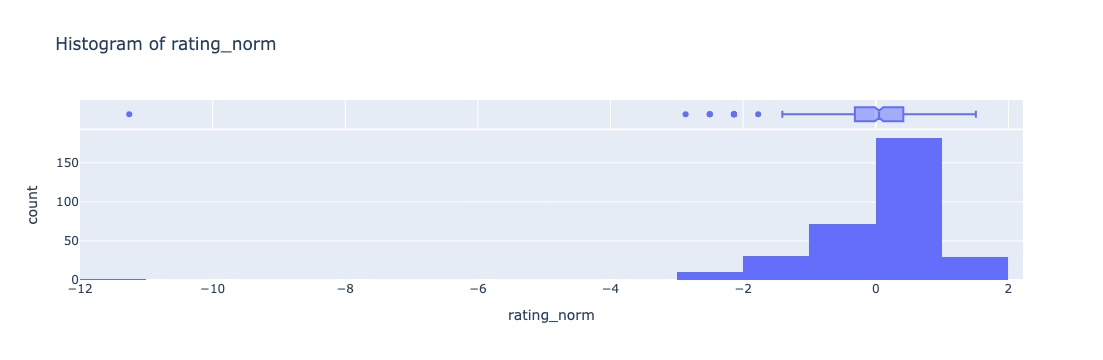

In [83]:
univariate('rating_norm')

## Correlation Analysis

In [29]:
def corr_matrix(x = None, y = None, df=df):
    """
    Display correlation dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation table
    
    """

    #Apply correlation matrix to entire dataframe, unless x and y variables are provided for filter
    if x == None:
        df = df
    else:
        df = df[df[x] == y]

    #Set plot size
    plt.figure(figsize=(10,8))

    #Create correlation matrix
    corr_matrix = df.corr(numeric_only = True)

    #Convert correlation matrix to heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

    #Set correlation matrix title
    plt.title('Correlation Matrix')

    #display correlation matrix
    plt.show()

def corr_table(x = None, y = None, df=df, t_min = 0.3, t_max = 1):
    """
    Display correlation dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation table
    
    """
    #Apply correlation matrix to entire dataframe, unless x and y variables are provided for filter
    
    
    if x == None:
        df = df
    else:
        df = df[df[x] == y]

    #Create correlation matrix
    corr = df.corr(numeric_only = True)

    #convert correlation matrix into list of lists
    result = []
    for row in corr.index:
        for col in corr:
            if row != col:
                result.append([row, col, corr[col][row]])
    
    #convert list into dataframe
    corr_df = pd.DataFrame(result, columns = ['var_1','var_2','corr'])

    #Sort dataframe on correlation
    corr_df = corr_df.sort_values('corr', ascending = False)
    
    #Filter variables that are directly correlated 
    corr_df = corr_df[~(corr_df['var_1'].str.contains('rating') & corr_df['var_2'].str.contains('rating'))]
    corr_df = corr_df[~(corr_df['var_1'].str.contains('cost|fee') & corr_df['var_2'].str.contains('cost|fee'))]
    corr_df = corr_df[~(corr_df['var_1'].str.contains('reviews') & corr_df['var_2'].str.contains('reviews'))]

    #Filter duplicate rows
    #corr_df = corr_df.iloc[::2]

    #Filter by minimum and maximum correlation threshold
    corr_df = corr_df[(abs(corr_df['corr']) > t_min) & (abs(corr_df['corr']) <= t_max)]

    #Add columns for category and type
    corr_df['category'] = x
    corr_df['type'] = y

    return corr_df


def corr_info(x = None, y = None, df = df, t_min = 0.3, t_max = 1):
    """
    Display correlation matrix and dataframe for numerical variables.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    y : string, optional
        The name of the categorical element for filter, default value = None
    df : dataframe, optional
        The dataframe to analyze, default value = df
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    
    Returns
    -------
    Correlation matrix with heatmap
    
    Correlation table
    
    """
    #Display correlation matrix
    corr_matrix(x, y, df)

    #Display correlation table
    display(corr_table(x, y, df, t_min, t_max))

def corr_cat(x, t_min=0.3, t_max = 1, df=df, f = 3):
    """
    Combine correlation tables across a single variable.
    
    Parameters
    ----------
    x : string, optional
        The name of the categorical variable for filter, default value = None
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.3
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    df : dataframe, optional
        The dataframe to analyze, default value = df
    f : int, optional
        Count of elements by which to filter, default value = 3
    
    Returns
    -------
    
    Combined correlation table
    
    """
    #Create empty dataframe
    corr_cat_df = pd.DataFrame()

    #Filter grouped dataframe by element count
    df = df.groupby(x, observed = False).filter(lambda x: len(x) > f)

    #Loop through types within category, combine dataframes
    for y in df[x].unique():
        temp_df = corr_table(x, y, t_min=t_min, t_max=t_max, df=df)
        corr_cat_df = pd.concat([corr_cat_df, temp_df], axis = 0)

    #Return combined dataframe
    return corr_cat_df

def corr_total(t_min = 0.9, t_max = 1, f = 10, df=df):
    """
    Combine correlation tables across all variables.
    
    Parameters
    ----------
    t_min : float, optional
        The minimum correlation threshold by which to filter, default value = 0.9
    t_max : float, optional
        The maximum correlation threshold by which to filter, default value = 1
    f : int, optional
        Count of elements by which to filter, default value = 10
    
    Returns
    -------
    
    Combined correlation table
    
    """
    #Create empty dataframe
    corr_total_df = pd.DataFrame()

    #Loop through variables within dataframe, combine dataframes
    for x in df.loc[:, df.columns != 'year'].select_dtypes(exclude='number').columns:
        temp_df = corr_cat(x, t_min=t_min, t_max=t_max, f = f, df=df)
        corr_total_df = pd.concat([corr_total_df, temp_df], axis = 0)

    #Sort dataframe on correlation
    corr_total_df = corr_total_df.sort_values('corr', ascending = False)

    #Return combined dataframe
    return corr_total_df

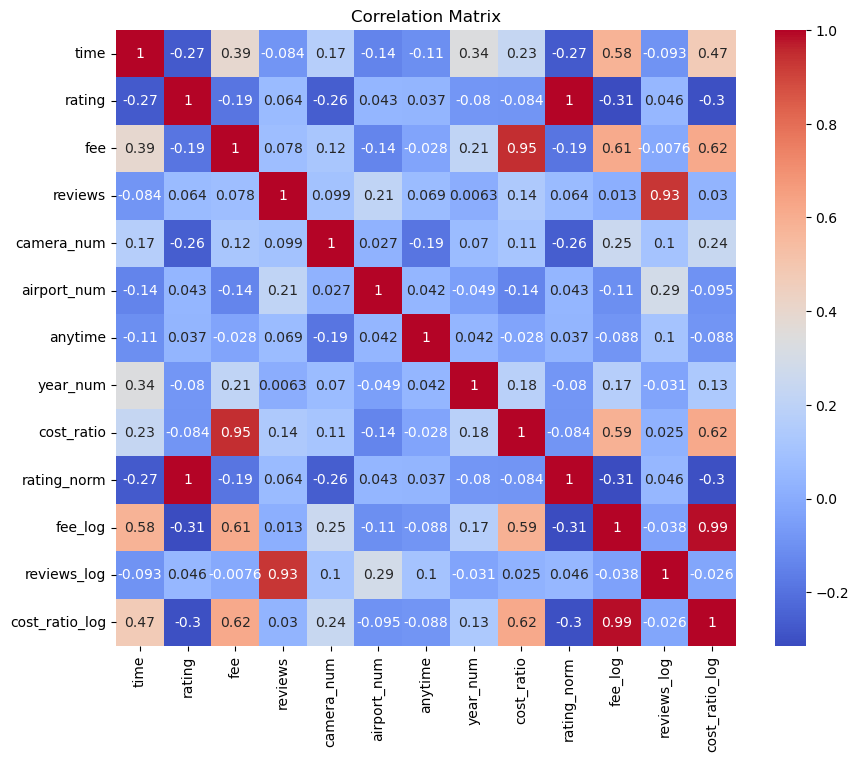

var_1           var_2      corr category  type
120         fee_log            time  0.579462     None  None
9              time         fee_log  0.579462     None  None
144  cost_ratio_log            time  0.472783     None  None
11             time  cost_ratio_log  0.472783     None  None
1              time             fee  0.390704     None  None
24              fee            time  0.390704     None  None
84         year_num            time  0.336223     None  None
6              time        year_num  0.336223     None  None
145  cost_ratio_log          rating -0.301630     None  None
23           rating  cost_ratio_log -0.301630     None  None
119     rating_norm  cost_ratio_log -0.301630     None  None
153  cost_ratio_log     rating_norm -0.301630     None  None
21           rating         fee_log -0.314632     None  None
117     rating_norm         fee_log -0.314632     None  None
121         fee_log          rating -0.314632     None  None
129         fee_log     rating_norm -0.314632     None  None

In [30]:
corr_info(df=df[df['year_num'] > 1400])

In [31]:
corr_total(df=df.drop(['rating_norm', 'reviews', 'fee', 'cost_ratio', 'camera_num', 'airport_num'], axis = 1), t_min = .6, f = 20)

var_1    var_2      corr      category  \
24  fee_log     time  0.659382          type   
3      time  fee_log  0.659382          type   
24  fee_log     time  0.649772          zone   
3      time  fee_log  0.649772          zone   
3      time  fee_log  0.634382  significance   
24  fee_log     time  0.634382  significance   
3      time  fee_log  0.628243    year_group   
24  fee_log     time  0.628243    year_group   
3      time  fee_log  0.619755          zone   
24  fee_log     time  0.619755          zone   
3      time  fee_log  0.619307    year_group   
24  fee_log     time  0.619307    year_group   

                                   type  
24                                 Fort  
3                                  Fort  
24                              Eastern  
3                               Eastern  
3                          Recreational  
24                         Recreational  
3   Late Modern and Contemporary Period  
24  Late Modern and Contemporary Period  
3                               Western  
24                              Western  
3            Independence and Partition  
24           Independence and Partition

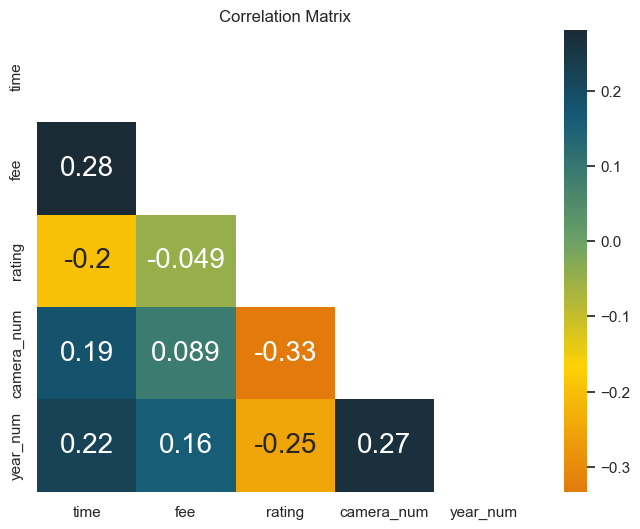

In [32]:
x = None
y = None
sns.set_theme(style="white")
cmap = load_cmap('Balistapus_undulatus', type='continuous', type_warning = False)

temp_df = df.drop(['rating_norm', 'reviews_log', 'fee_log', 'cost_ratio_log'], axis = 1)
temp_df = df[['time','fee','rating','camera_num','year_num']]

#Set plot size
plt.figure(figsize=(8,6))

#Create correlation matrix
corr_matrix_df = temp_df.corr(numeric_only = True)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix_df)
mask[np.triu_indices_from(mask)] = True

#Convert correlation matrix to heatmap
sns.heatmap(corr_matrix_df, annot=True, cmap=cmap, mask=mask, annot_kws = {'size': 20}, center = 0)

#Set correlation matrix title
plt.title('Correlation Matrix')

#display correlation matrix
plt.show()

## Bivariate Analysis

In [34]:
def bivar_box(x, y, df=df, text='name', cat=None):
    """
    Display boxplots for discrete numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for outlier points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    
    Returns
    -------
    
    Box plots for each discrete number category.
    
    """
    #filter outliers
    temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #create figure
    fig = px.box(temp_df, x=x, y=y, hover_name=text, color = cat, title = y + " vs " + x)

    return fig

def outliers(x, y, df=df):
    """
    Create dataframe of outliers based on category and type.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Dataframe of outliers.
    
    """

    #create outliers dataframe, remove NaNs
    outliers_df = df[[x, y]].dropna()

    #filter outliers from dataframe
    outliers_df = outliers_df.loc[~outliers_df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #merge filtered dataframe onto original dataframe
    outliers_df = outliers_df.merge(df, how = 'left', left_index = True, right_index = True, 
                              suffixes = ['', '_y'])[['name', x, y]].sort_values(by = y)
    
    return outliers_df

def bivar_sca(x, y, df=df, text = 'name', cat = None):
    """
    Display scatter plot for numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    
    Returns
    -------
    
    Scatter plot for numerical category.
    
    """
    #filter outliers
    temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

    #create figure
    fig = px.scatter(temp_df, x=x, y=y, color = cat, hover_name=text, title = y + " vs " + x)

    return fig


def bivariate(x, y, df=df, text = 'name', cat = None, type = 'sca'):
    """
    Display plot for numerical categories.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the categorical element for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    text : string, optional
        The hover name value for points, default value = 'name'
    cat : string, optional
        Category by which to color code data, default value = None
    type : string, optional
        Type of plot to produce, default value = 'sca'
        Produce scatter plot : type = 'sca'
        Produce box plot : type = 'box'
    
    Returns
    -------
    
    Plot and outliers table.
    
    """

    #Display either scatter or box plot, depending on value of 'type'
    if type == 'sca':
        bivar_sca(x, y, df, text, cat).show()
    elif type == 'box':
        bivar_box(x, y, df, text, cat).show()
    #return outliers dataframe
    return display(outliers(x, y))
    


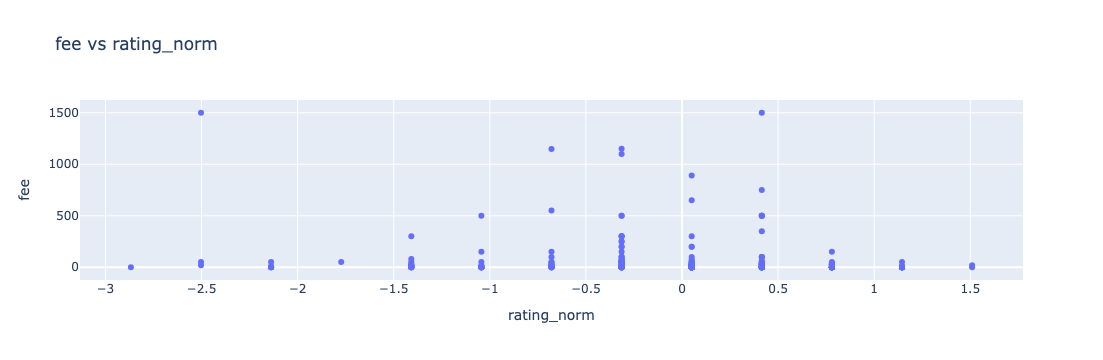

name  rating_norm   fee
26            Imagicaa   -11.256880  1149
47        Eden Gardens    -1.408513  2500
161   Paragliding Site     1.144767  2500
68   Gir National Park     0.050504  3500
72          Rann Utsav     1.509522  7500

In [35]:
bivariate('rating_norm', 'fee')

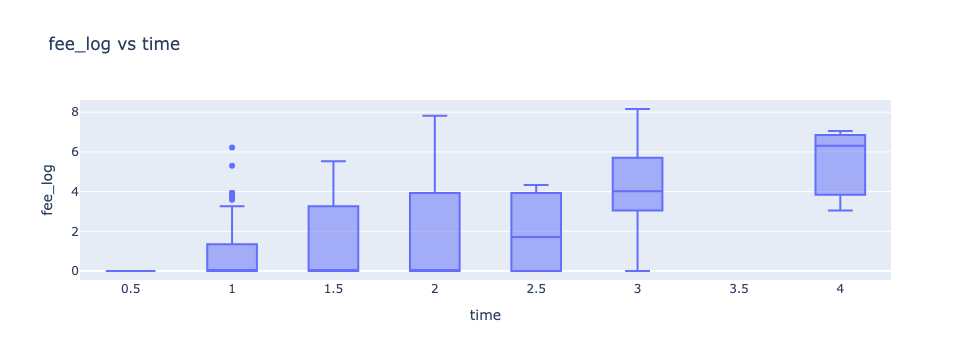

name  time   fee_log
162              Triund Trek   5.0  0.000000
200            Amarnath Cave   6.0  0.000000
198             Vaishno Devi   5.0  0.000000
2          Akshardham Temple   5.0  4.110874
15   National Science Centre   5.0  4.262680
180        Valley of Flowers   5.0  5.017280
78              Science City   7.0  6.216606
110  Wonderla Amusement Park   5.5  6.621406
24               Essel World   5.0  7.047517
26                  Imagicaa   5.0  7.047517
167          Kufri Fun World   5.0  7.313887
72                Rann Utsav   3.0  8.922792

In [36]:
bivariate('time', 'fee_log', type='box')

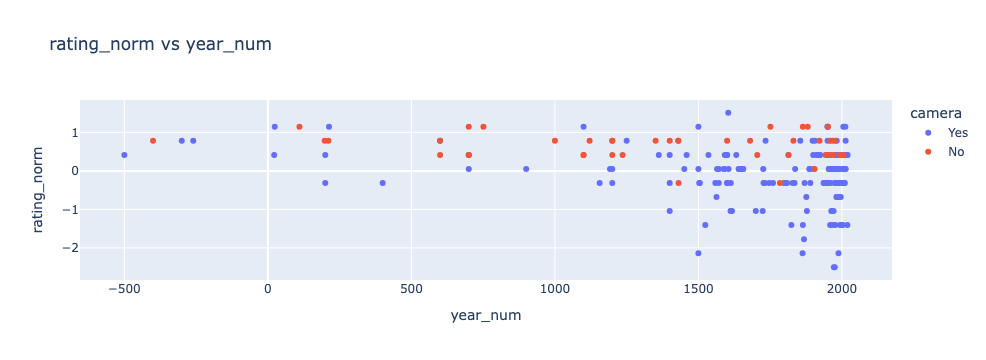

name  year_num  rating_norm
26                       Imagicaa    2013.0   -11.256880
229                 Barabati Fort    -987.0     0.050504
136  Khajuraho Group of Monuments    -850.0     0.780013
140     Mahakaleshwar Jyotirlinga   -3500.0     1.144767
174              Badrinath Temple    -820.0     1.144767

In [37]:
bivariate('year_num', 'rating_norm', cat = 'camera')

In [38]:

f = 10
t_min = 0.9
t_max = 1
temp_df = df

def corr_total_f(t_min = 0.9, t_max = 1, f = 10, df=df):
    

    temp_df = df.drop(['anytime', 'camera_num', 'airport_num'], axis = 1)


    temp_df = corr_total(t_min = t_min, t_max = t_max, f = f, df=temp_df)

    temp_df = temp_df[temp_df['var_2'] != 'year_num']


    return temp_df

In [39]:
corr_total_f()

var_1           var_2      corr category           type
42    year_num         fee_log  0.996861    state            Goa
42    year_num         fee_log  0.996861     city            Goa
44    year_num  cost_ratio_log  0.996861    state            Goa
40    year_num      cost_ratio  0.996861    state            Goa
44    year_num  cost_ratio_log  0.996861     city            Goa
40    year_num      cost_ratio  0.996861     city            Goa
38    year_num             fee  0.996861     city            Goa
38    year_num             fee  0.996861    state            Goa
29     reviews             fee  0.932003    state  Uttar Pradesh
20         fee         reviews  0.932003    state  Uttar Pradesh
48  cost_ratio         reviews  0.930288    state  Uttar Pradesh
31     reviews      cost_ratio  0.930288    state  Uttar Pradesh
45  cost_ratio            time  0.922579     type      Waterfall
4         time      cost_ratio  0.922579     type      Waterfall
1         time             fee  0.914410     type      Waterfall
18         fee            time  0.914410     type      Waterfall
29     reviews             fee  0.912657     zone        Central
20         fee         reviews  0.912657     zone        Central
48  cost_ratio         reviews  0.911177     zone        Central
31     reviews      cost_ratio  0.911177     zone        Central
41    year_num     rating_norm -0.980883     type           Lake
37    year_num          rating -0.980883     type           Lake

In [40]:

f = 10
t_min = 0.9
t_max = 1
temp_df = df



temp_df = temp_df.drop(['anytime', 'camera_num', 'airport_num'], axis = 1)


temp_df = corr_total(t_min = t_min, t_max = t_max, f = f, df=temp_df)

temp_df = temp_df[temp_df['var_2'] != 'year_num']


temp_df

var_1           var_2      corr category           type
42    year_num         fee_log  0.996861    state            Goa
42    year_num         fee_log  0.996861     city            Goa
44    year_num  cost_ratio_log  0.996861    state            Goa
40    year_num      cost_ratio  0.996861    state            Goa
44    year_num  cost_ratio_log  0.996861     city            Goa
40    year_num      cost_ratio  0.996861     city            Goa
38    year_num             fee  0.996861     city            Goa
38    year_num             fee  0.996861    state            Goa
29     reviews             fee  0.932003    state  Uttar Pradesh
20         fee         reviews  0.932003    state  Uttar Pradesh
48  cost_ratio         reviews  0.930288    state  Uttar Pradesh
31     reviews      cost_ratio  0.930288    state  Uttar Pradesh
45  cost_ratio            time  0.922579     type      Waterfall
4         time      cost_ratio  0.922579     type      Waterfall
1         time             fee  0.914410     type      Waterfall
18         fee            time  0.914410     type      Waterfall
29     reviews             fee  0.912657     zone        Central
20         fee         reviews  0.912657     zone        Central
48  cost_ratio         reviews  0.911177     zone        Central
31     reviews      cost_ratio  0.911177     zone        Central
41    year_num     rating_norm -0.980883     type           Lake
37    year_num          rating -0.980883     type           Lake

state
Goa
0


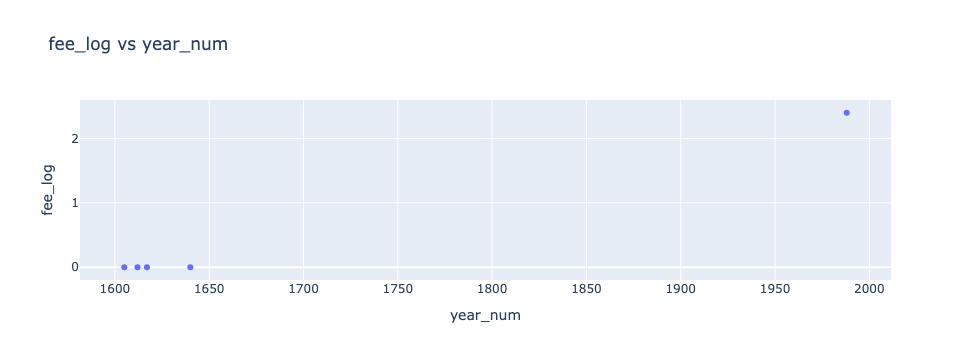

city
Goa
1


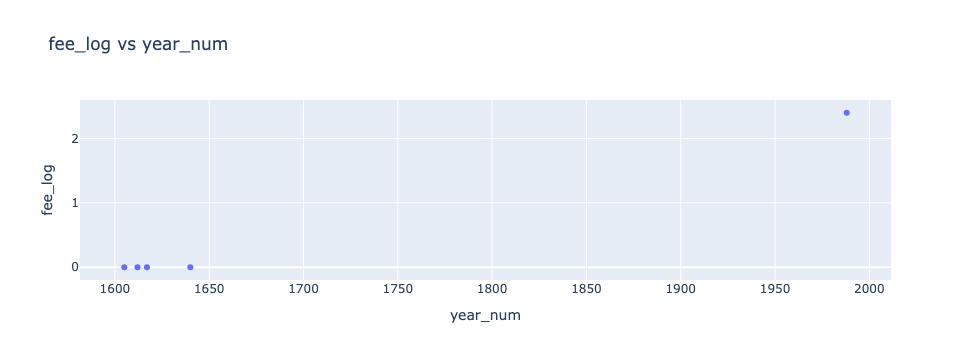

state
Goa
2


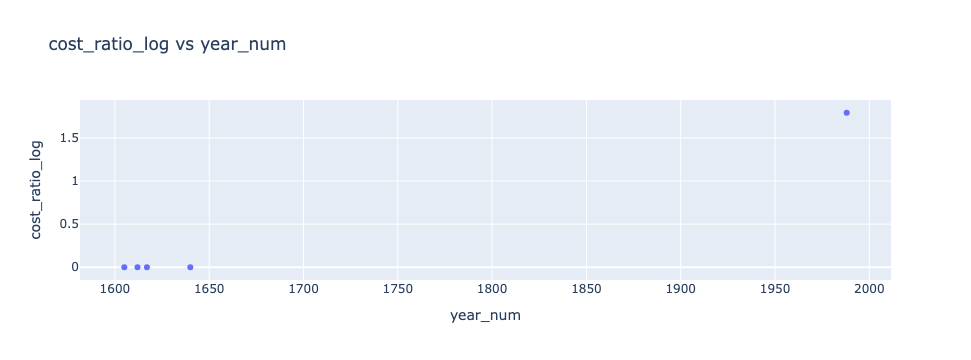

state
Goa
3


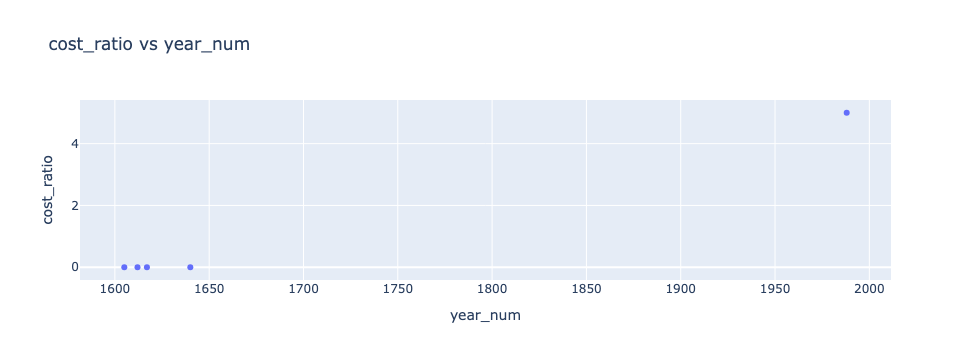

city
Goa
4


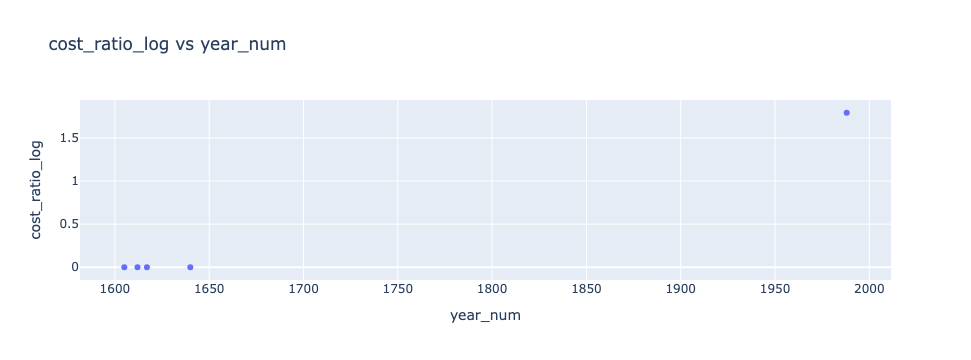

city
Goa
5


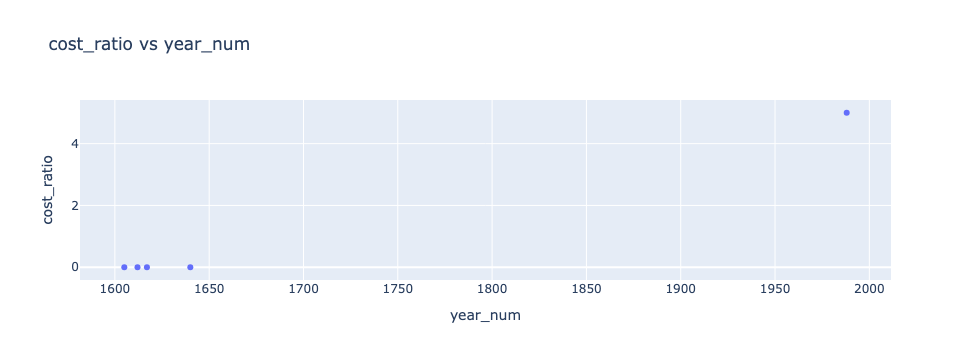

city
Goa
6


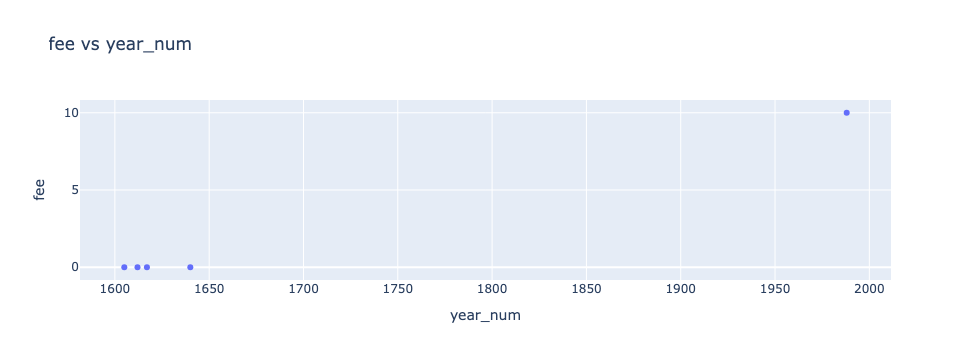

state
Goa
7


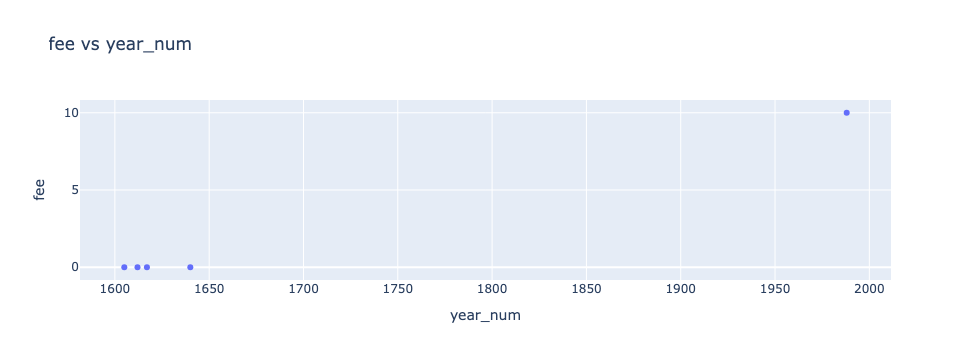

state
Uttar Pradesh
8


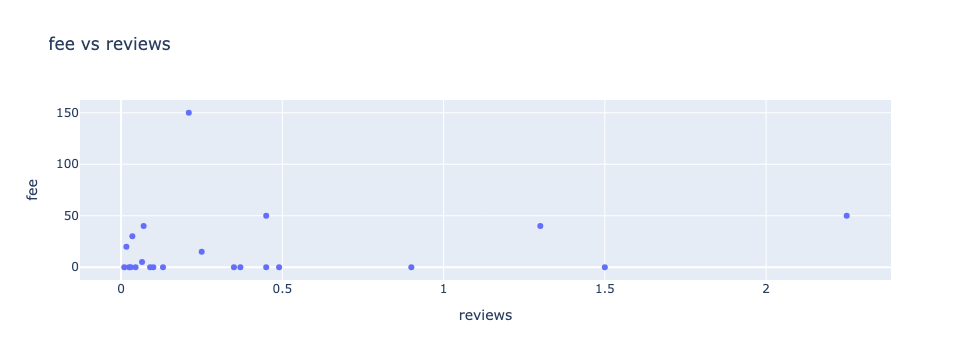

state
Uttar Pradesh
9


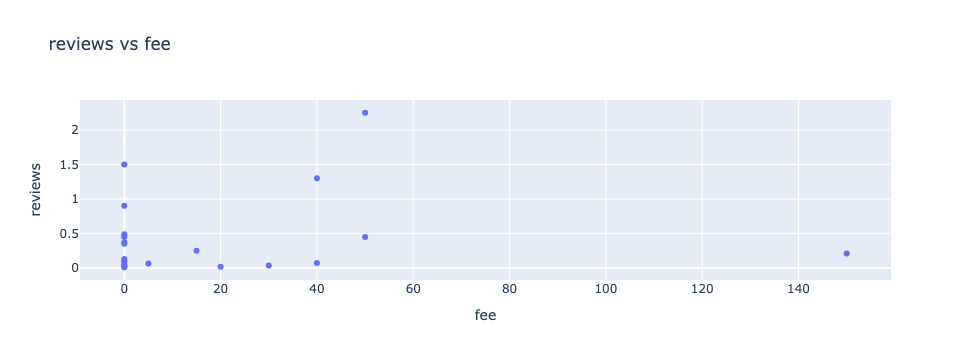

state
Uttar Pradesh
10


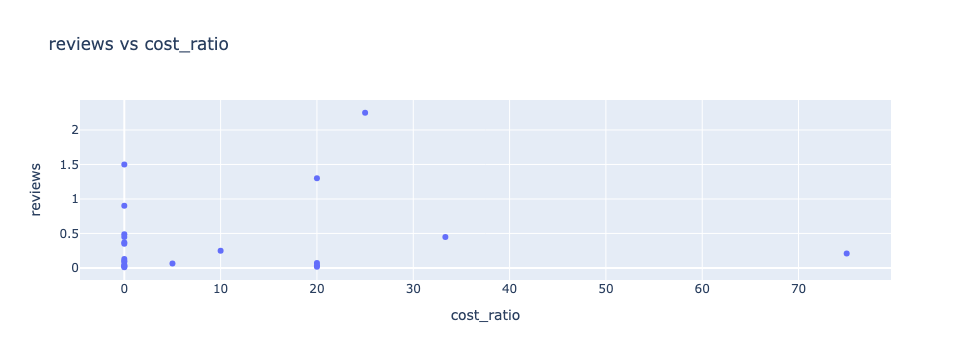

state
Uttar Pradesh
11


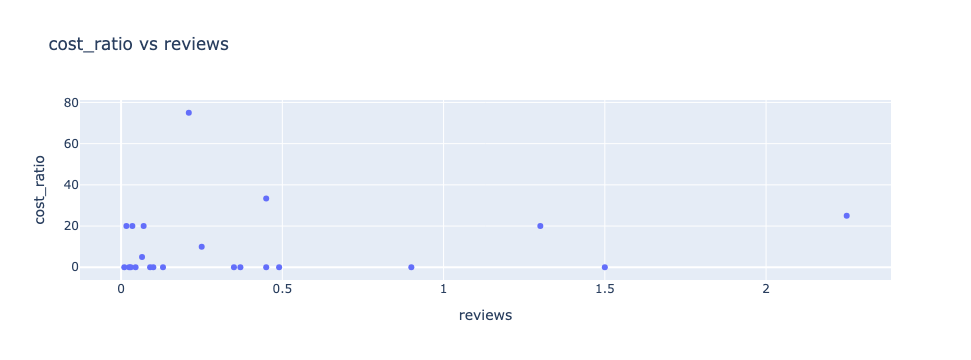

type
Waterfall
12


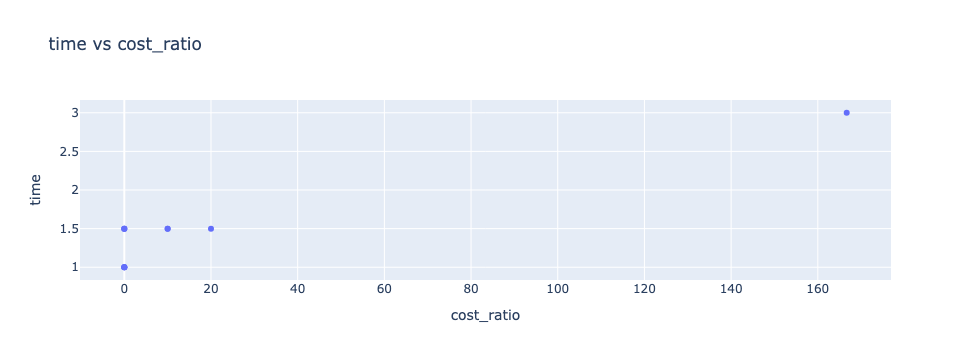

type
Waterfall
13


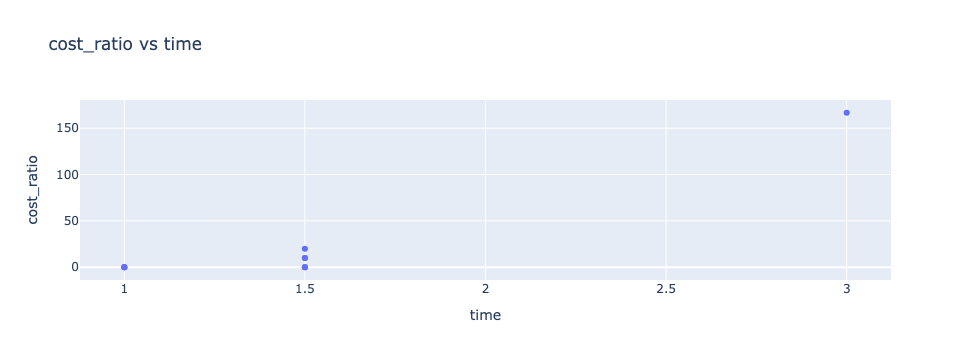

type
Waterfall
14


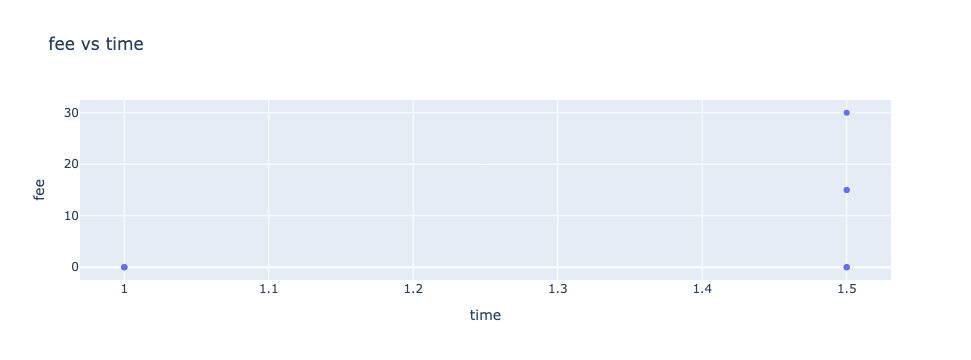

type
Waterfall
15


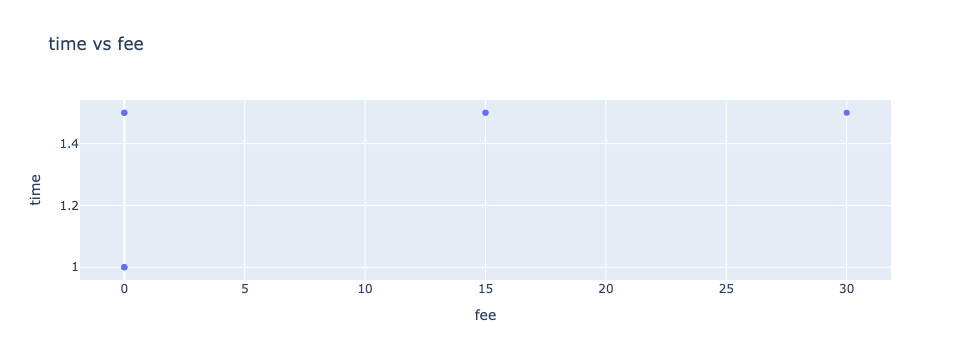

zone
Central
16


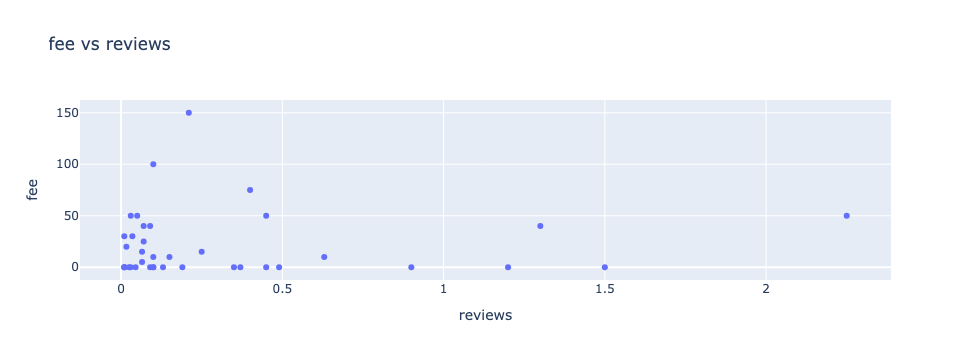

zone
Central
17


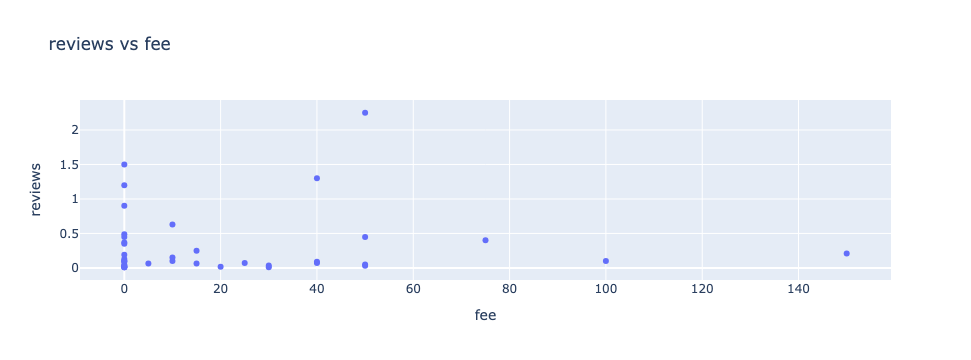

zone
Central
18


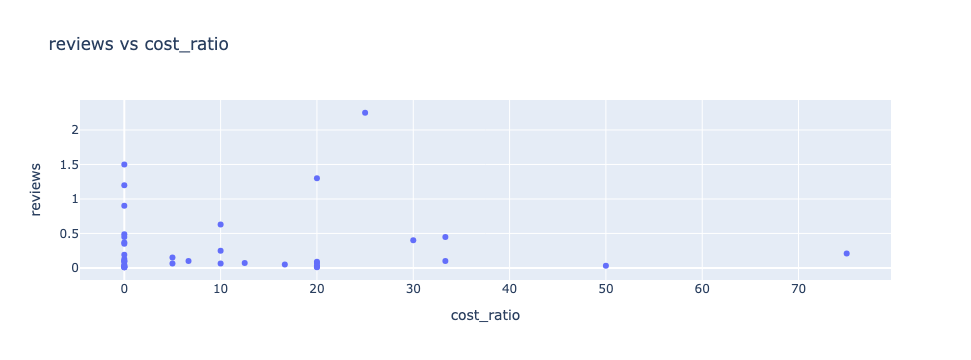

zone
Central
19


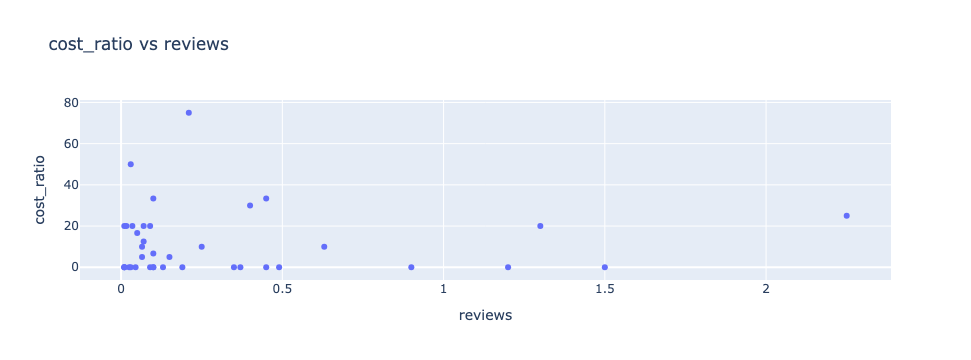

type
Lake
20


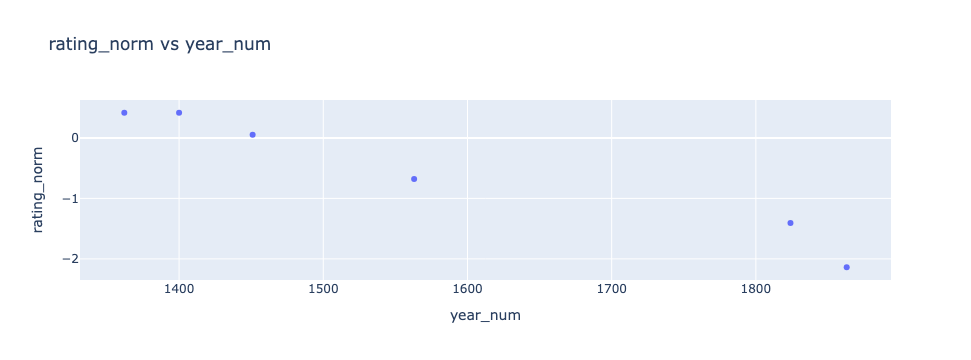

type
Lake
21


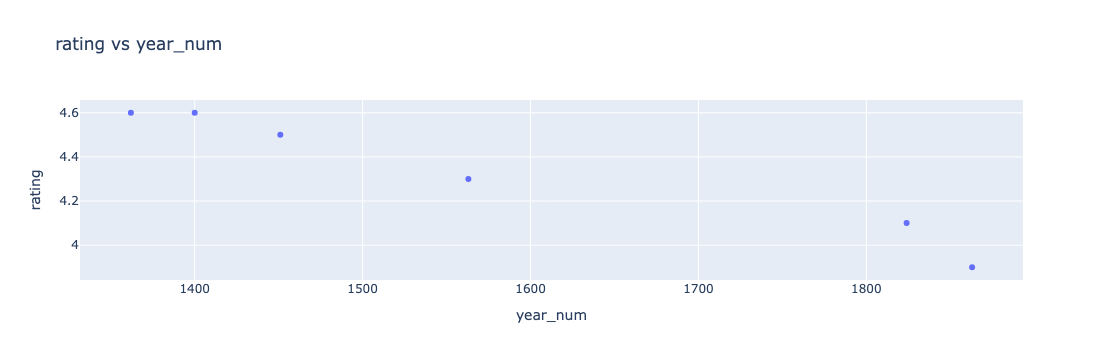

In [41]:
temp_df = corr_total_f()

for loc in range(0, len(temp_df)):
    var_1, var_2, corr, category, type = temp_df.iloc[loc]
    print(category)
    print(type)
    print(loc)
    display(bivar_sca(var_1, var_2, df = df[df[category] == type]))

Categorical analysis

## Categorical Analysis

In [44]:
def cat_hist(x, df=df):
    """
    Create bar chart showing count of each type within variable x.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of count.
    
    """
    #filter dataframe on elements with count greater than 3
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)

    #create figure
    fig = px.histogram(temp_df, x=x).update_xaxes(categoryorder="total descending")

    return fig


def cat_bar(x, y, df=df):
    """
    Create bar chart showing average value of each type y within variable x.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y : string
        The name of the numerical element for bar value.
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of average y-value.
    
    """
    #filter dataframe on elements with count greater than 3. Compute mean y value of each type.
    temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    x, observed = False)[[y]].mean().sort_values(y, ascending = False).dropna()

    #create figure
    fig = px.bar(temp_df, y=y)

    #plot settings
    fig.update_layout(
        title="Average rating for each "+ x + " category",
        xaxis_title="",
        yaxis_title=y,)

    return fig        


def categorical(x, y, df=df):
    """
    Produce bar chart of counts.
    Produce bar chart of average y value.
    Display ANOVA stats
    Display t-test dataframe.
    
    Parameters
    ----------
    x : string
        The name of the categorical variable for filter
    y ; string
        The name of the numerical element to compute tests.
    df : dataframe, optional
        The dataframe to analyze, default value = df
    
    Returns
    -------
    
    Bar chart of counts.
    Bar chart of average y value.
    ANOVA stats
    t-test dataframe
    
    """

    cat_hist(x, df=df).show()
    
    cat_bar(x, y, df=df).show()
    
    print(pg.anova(data=df, dv=y, between=x))

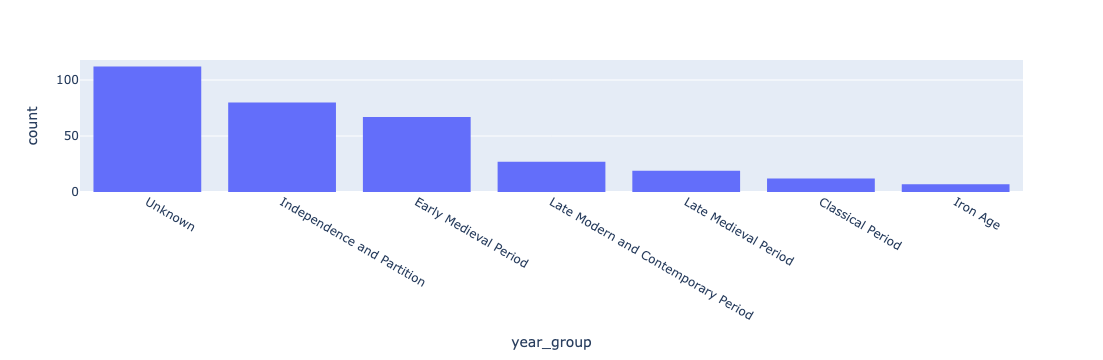

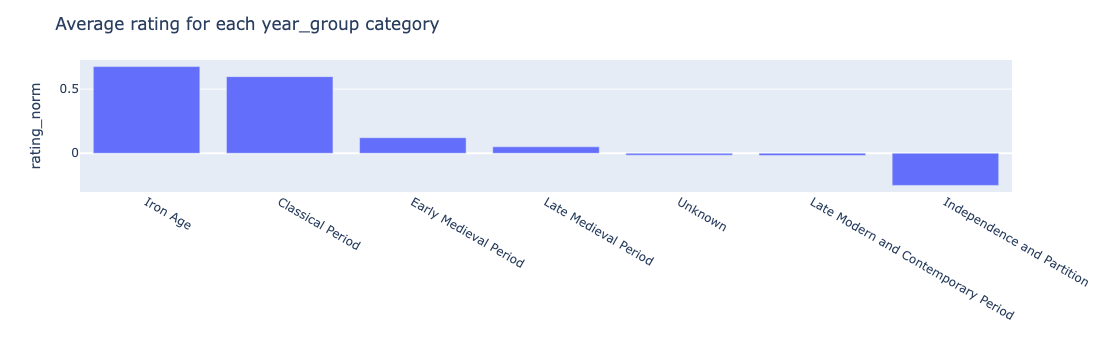

       Source  ddof1  ddof2         F     p-unc       np2
0  year_group      7    317  2.172245  0.036403  0.045772


In [45]:
categorical('year_group', 'rating_norm')

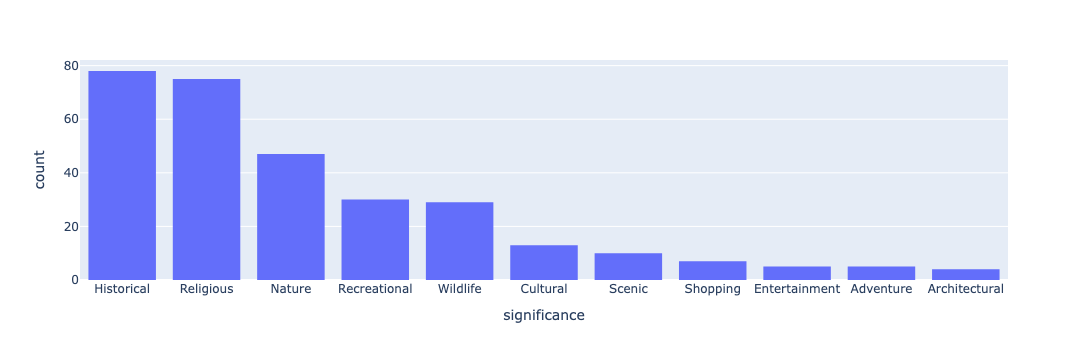

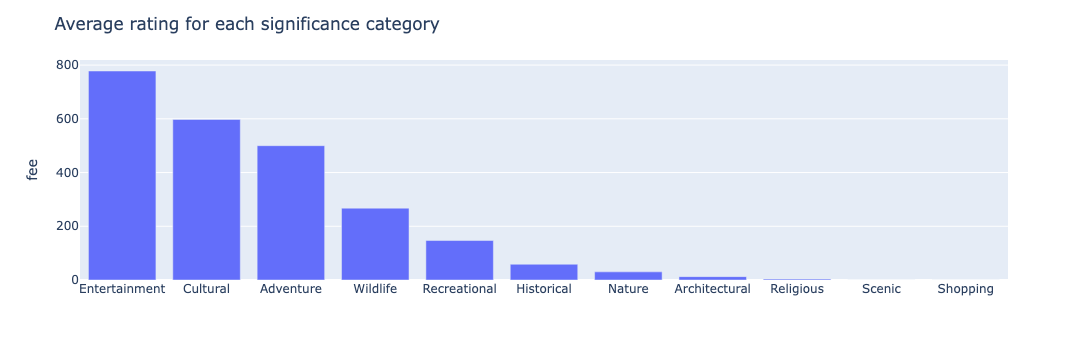

         Source  ddof1  ddof2         F    p-unc      np2
0  significance     24    300  2.610671  0.00009  0.17277


In [235]:
categorical('significance', 'fee')

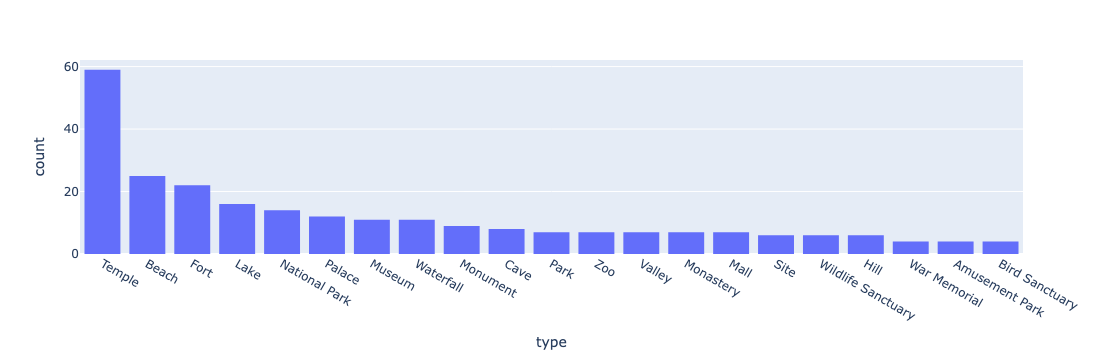

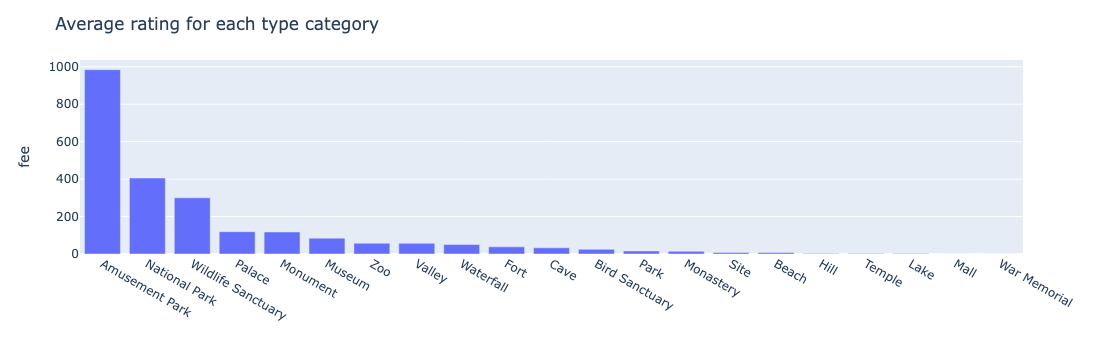

  Source  ddof1  ddof2         F         p-unc       np2
0   type     77    247  3.955561  1.515394e-16  0.552194


In [239]:
categorical('type', 'fee')

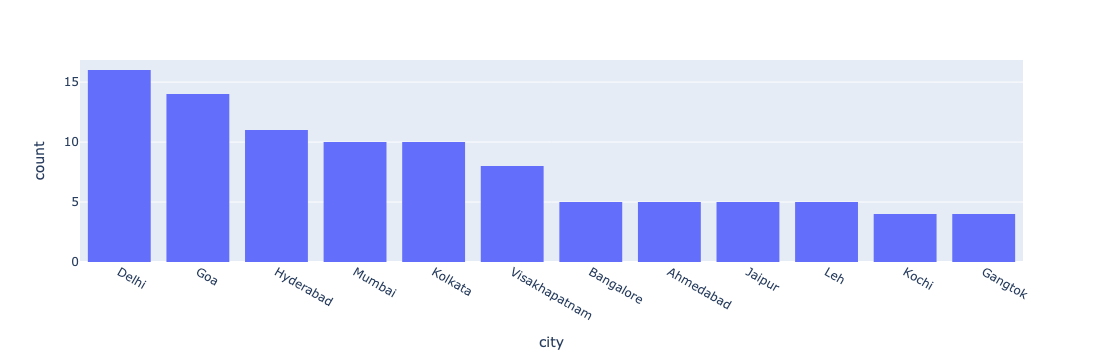

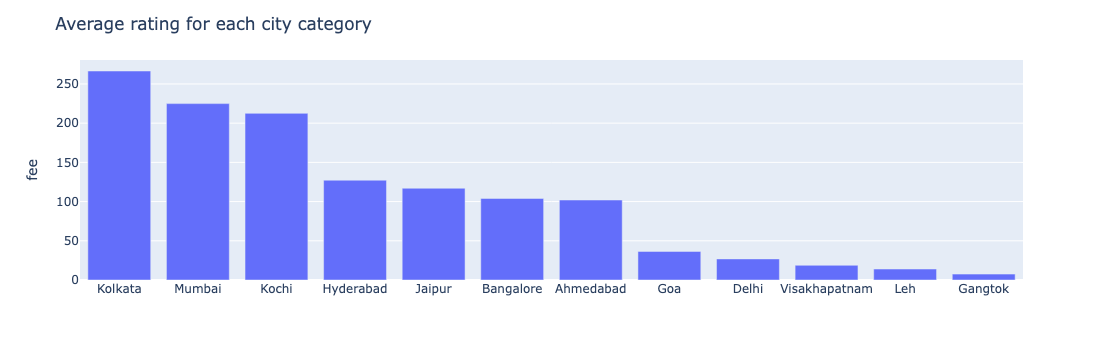

  Source  ddof1  ddof2         F         p-unc       np2
0   city    212    112  3.384627  6.715543e-12  0.864986


In [231]:
categorical('city', 'fee')

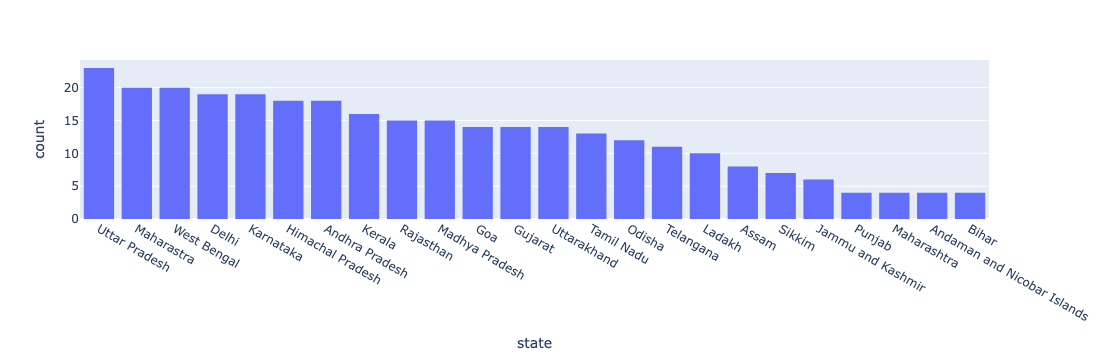

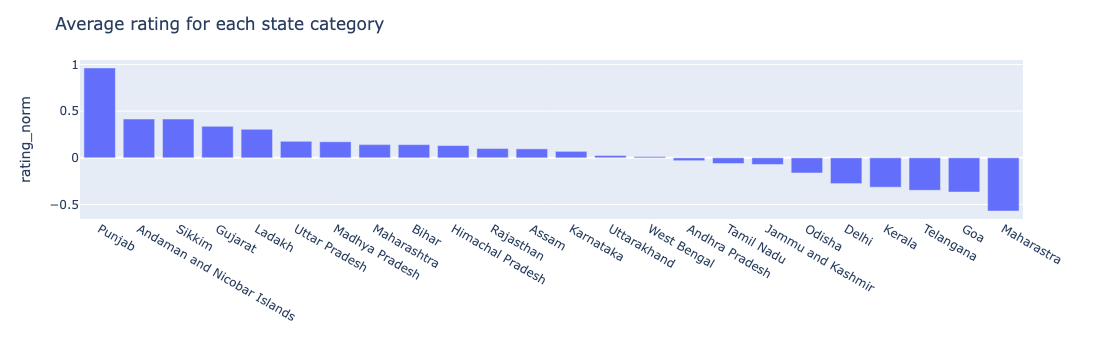

  Source  ddof1  ddof2         F     p-unc       np2
0  state     32    292  0.808365  0.761932  0.081379


In [49]:
categorical('state', 'rating_norm')

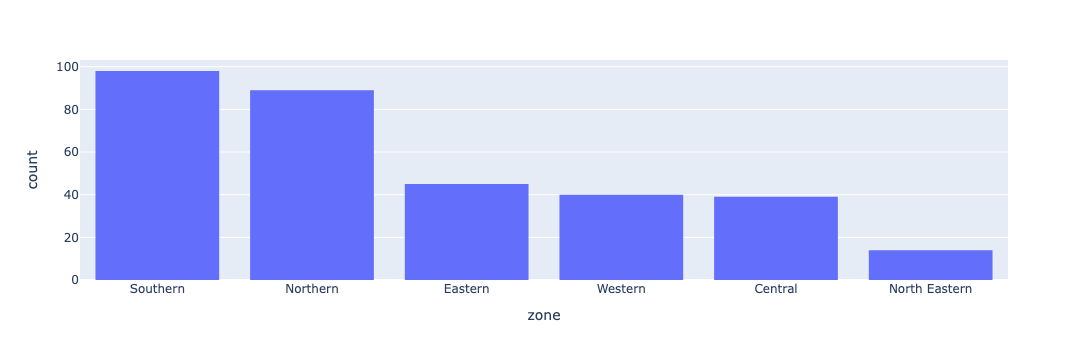

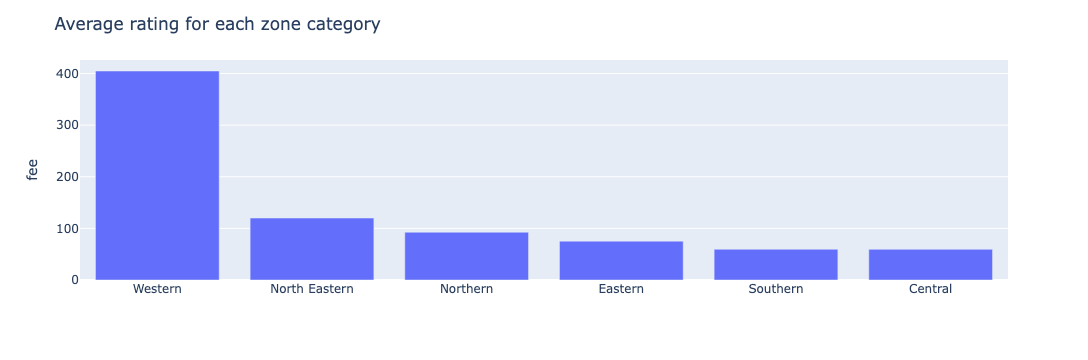

  Source  ddof1  ddof2         F     p-unc       np2
0   zone      5    319  2.845871  0.015697  0.042701


In [241]:
categorical('zone', 'fee')

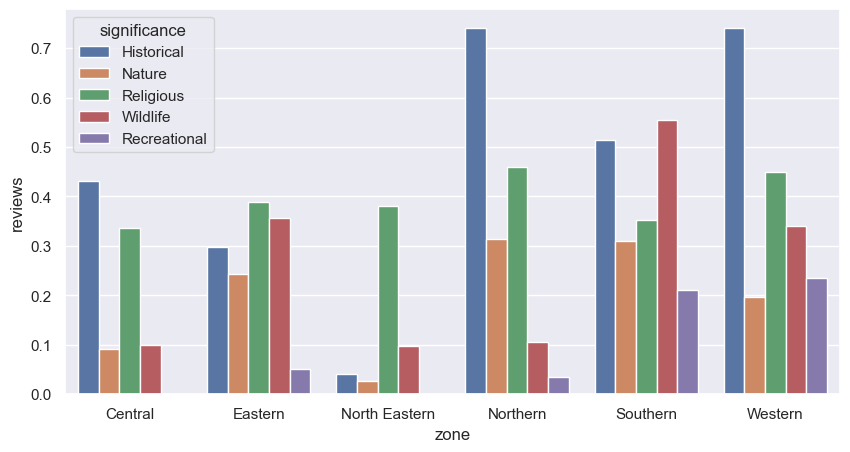

In [490]:
x= 'significance'
y = 'reviews'

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)

temp_df = df.groupby(x, observed = False).count().sort_values('zone', ascending = False)

filter = temp_df[['zone']].head().index



temp_df = df[df[x].isin(filter)]

temp_df = temp_df.groupby(['zone',x]).mean(numeric_only = True)
plt.figure(figsize=(10, 5))
sns.set_theme(style="darkgrid")
sns.barplot(x="zone", y=y, data=temp_df, errorbar=None, hue = x);
#plt.yscale("log")

Index(['Wildlife', 'Recreational', 'Historical', 'Nature', 'Religious'], dtype='object', name='significance')


<Axes: xlabel='cost_ratio', ylabel='significance'>

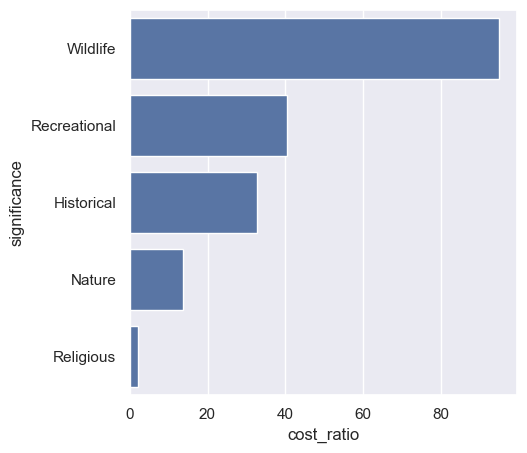

In [508]:
x = 'significance'
y = 'cost_ratio'
temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)


temp_df = temp_df.groupby(x, observed = False).count().sort_values('rating', ascending = False)

filter = temp_df[['rating']].head().index

temp_df = df[df[x].isin(filter)]

temp_df = temp_df[[x, y]].groupby(x, observed = False).mean().sort_values('cost_ratio', ascending = False).head()

print(temp_df.index)

#.mean('cost_ratio').sort_values('cost_ratio', ascending = False).head()



# temp_df = df.groupby('zone')[['cost_ratio']].mean().sort_values('cost_ratio', ascending = False)

# temp_df.reset_index(inplace = True)

# temp_df = df


plt.figure(figsize=(5, 5))
sns.set_theme(style="darkgrid")
#plt.xscale("log")
sns.barplot(y="significance", x=y, data=temp_df, orient = 'h')


<Axes: xlabel='cost_ratio', ylabel='significance'>

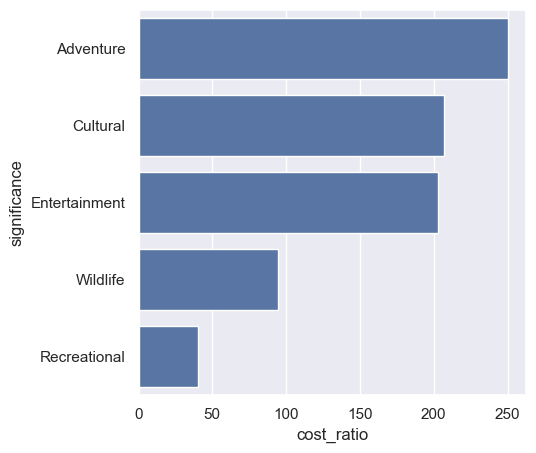

In [475]:
x = 'significance'
y = 'cost_ratio'
temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)

temp_df = temp_df[[x, y]].groupby(x, observed = False).mean().sort_values('cost_ratio', ascending = False).head()

temp_df

#.mean('cost_ratio').sort_values('cost_ratio', ascending = False).head()



# temp_df = df.groupby('zone')[['cost_ratio']].mean().sort_values('cost_ratio', ascending = False)

# temp_df.reset_index(inplace = True)

# temp_df = df


plt.figure(figsize=(5, 5))
sns.set_theme(style="darkgrid")
#plt.xscale("log")
sns.barplot(y="significance", x=y, data=temp_df, orient = 'h')


<Axes: xlabel='cost_ratio', ylabel='zone'>

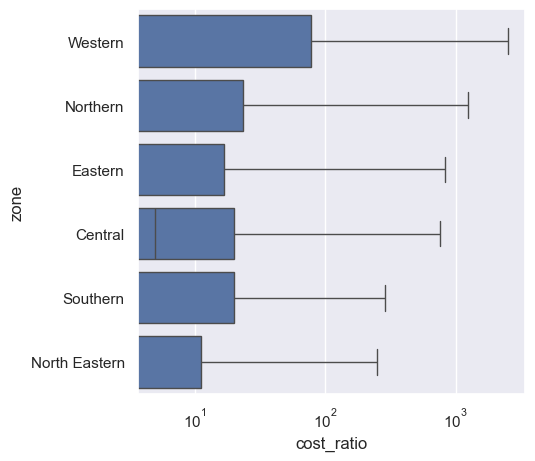

In [479]:
y = 'cost_ratio'


temp_df = df.groupby('zone')[['cost_ratio']].mean().sort_values('cost_ratio', ascending = False)

temp_df.reset_index(inplace = True)

temp_df = df.sort_values('cost_ratio', ascending = False)


plt.figure(figsize=(5, 5))
sns.set_theme(style="darkgrid")
plt.xscale("log")
sns.boxplot(y="zone", x=y, data=temp_df, orient = 'h')


<Axes: xlabel='cost_ratio', ylabel='zone'>

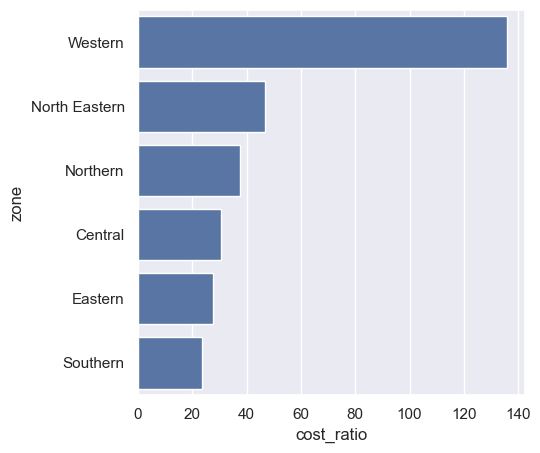

In [411]:
x= 'type'
y = 'cost_ratio'

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)

temp_df = df.groupby(x, observed = False).count().sort_values('zone', ascending = False)

filter = temp_df[['zone']].head().index



temp_df = df[df[x].isin(filter)]

temp_df = temp_df.groupby(['zone',x]).mean(numeric_only = True)

temp_df = df.groupby('zone')[['cost_ratio']].mean().sort_values('cost_ratio', ascending = False)

temp_df.reset_index(inplace = True)


plt.figure(figsize=(5, 5))
sns.set_theme(style="darkgrid")

sns.barplot(y="zone", x=y, data=temp_df, errorbar=None, orient = 'h')

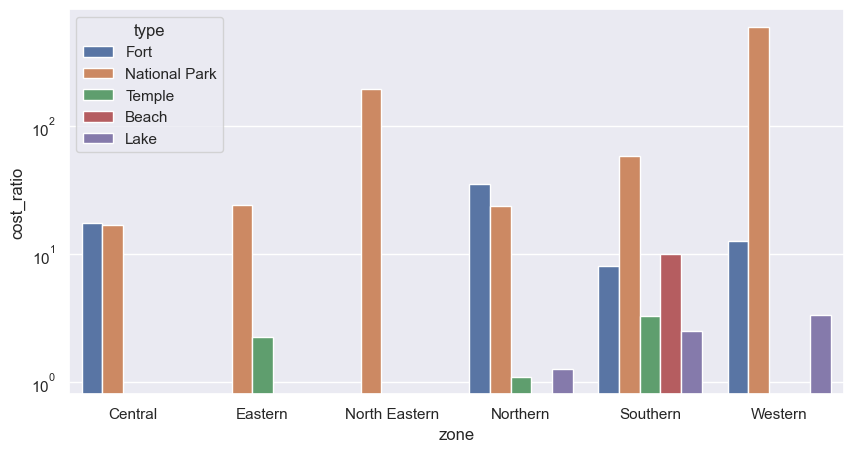

In [289]:
x= 'type'
y = 'cost_ratio'

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)

temp_df = df.groupby(x, observed = False).count().sort_values('zone', ascending = False)

filter = temp_df[['zone']].head().index



temp_df = df[df[x].isin(filter)]

temp_df = temp_df.groupby(['zone',x]).mean(numeric_only = True)
plt.figure(figsize=(10, 5))
sns.set_theme(style="darkgrid")
sns.barplot(x="zone", y=y, data=temp_df, errorbar=None, hue = x);
plt.yscale("log")

In [494]:
filter

Index(['Historical', 'Religious', 'Nature', 'Recreational', 'Wildlife'], dtype='object', name='significance')

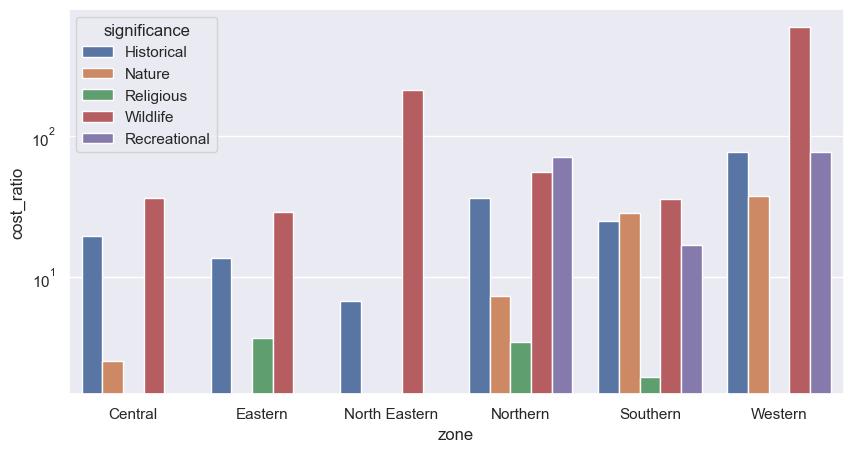

In [514]:
x= 'significance'
y = 'cost_ratio'

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)

#temp_df = df.groupby(x, observed = False).mean(numeric_only = True).sort_values('rating', ascending = False)

temp_df = temp_df.groupby(x, observed = False).count().sort_values('rating', ascending = False)

filter = temp_df[['rating']].head().index



temp_df = df[df[x].isin(filter)]

temp_df = temp_df.groupby(['zone',x]).mean(numeric_only = True)
plt.figure(figsize=(10, 5))
sns.set_theme(style="darkgrid")
sns.barplot(x="zone", y=y, data=temp_df, errorbar=None, hue = x);
plt.yscale("log")

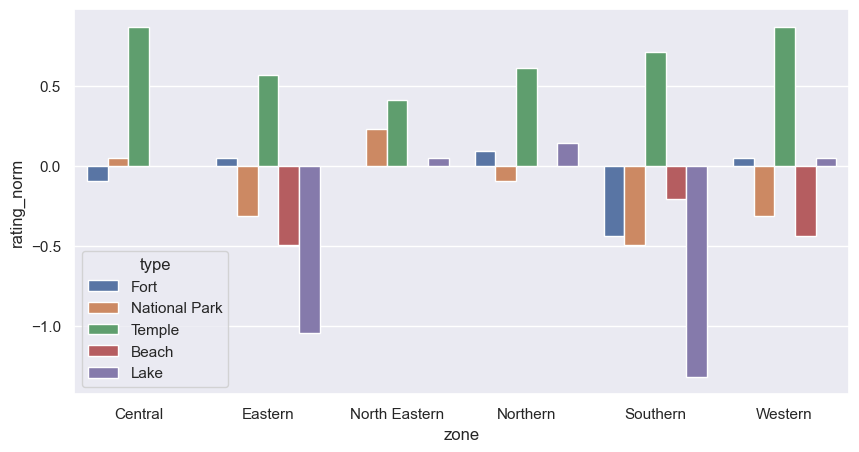

In [309]:
x= 'type'
y = 'rating_norm'

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)

#temp_df = temp_df.groupby(x, observed = False).mean(numeric_only = True).sort_values('rating', ascending = False)

temp_df = temp_df.groupby(x, observed = False).count().sort_values('rating', ascending = False)

filter = temp_df[['rating']].head().index



temp_df = df[df[x].isin(filter)]

temp_df = temp_df.groupby(['zone',x]).mean(numeric_only = True)
plt.figure(figsize=(10, 5))
sns.set_theme(style="darkgrid")
sns.barplot(x="zone", y=y, data=temp_df, errorbar=None, hue = x);
#plt.yscale("log")

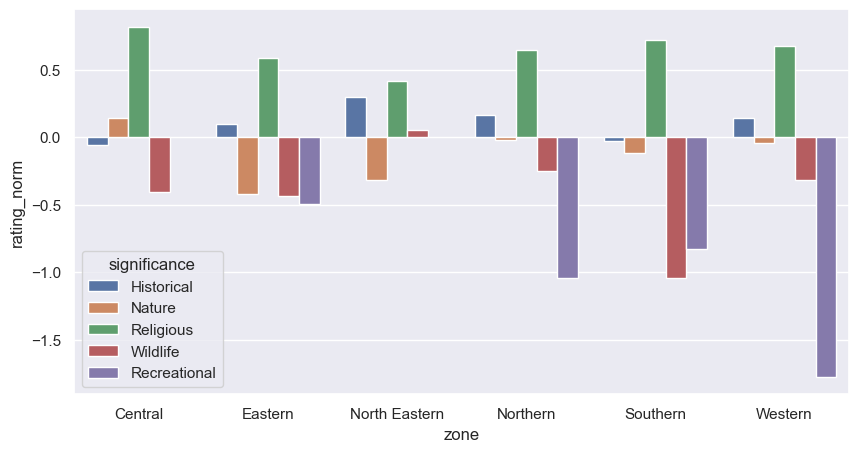

In [305]:
x= 'significance'
y = 'rating_norm'

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)

#temp_df = temp_df.groupby(x, observed = False).mean(numeric_only = True).sort_values('rating', ascending = False)

temp_df = temp_df.groupby(x, observed = False).count().sort_values('rating', ascending = False)

filter = temp_df[['rating']].head().index



temp_df = df[df[x].isin(filter)]

temp_df = temp_df.groupby(['zone',x]).mean(numeric_only = True)
plt.figure(figsize=(10, 5))
sns.set_theme(style="darkgrid")
sns.barplot(x="zone", y=y, data=temp_df, errorbar=None, hue = x);
#plt.yscale("log")

## Geo Spatial

In [52]:
def filter_locations(df, center_lat, center_lon, max_distance):
    """
    Filters a dataframe based on distance from a center point.

    Args:
        df: The dataframe containing latitude and longitude columns.
        center_lat: Latitude of the center point.
        center_lon: Longitude of the center point.
        max_distance: Maximum distance in kilometers.

    Returns:
        Filtered dataframe.
    """

    def calculate_distance(row):
        coords_1 = (center_lat, center_lon)
        coords_2 = (row['lat'], row['lon'])
        return geodesic(coords_1, coords_2).km

    df['distance'] = df.apply(calculate_distance, axis=1)
    return df[df['distance'] <= max_distance]

In [53]:
def filter_locations(df, center_lat, center_lon, max_distance):
    """
    Filters a dataframe based on distance from a center point.

    Args:
        df: The dataframe containing latitude and longitude columns.
        center_lat: Latitude of the center point.
        center_lon: Longitude of the center point.
        max_distance: Maximum distance in kilometers.

    Returns:
        Filtered dataframe.
    """

    def calculate_distance(row):
        coords_1 = (center_lat, center_lon)
        coords_2 = (row['lat'], row['lon'])
        return geodesic(coords_1, coords_2).km

    df['distance'] = df.apply(calculate_distance, axis=1)
    return df[df['distance'] <= max_distance]

In [54]:
def calculate_circumcenter(x1, y1, x2, y2, x3, y3):
    """
    Calculates the circumcenter of a triangle formed by three points.
    The circumcenter is the point that is equidistant from all three vertices.
    """

    # Calculate the midpoints of two sides of the triangle
    midpoint1_x = (x1 + x2) / 2
    midpoint1_y = (y1 + y2) / 2
    midpoint2_x = (x2 + x3) / 2
    midpoint2_y = (y2 + y3) / 2

    # Calculate the slopes of the two sides
    slope1 = (y2 - y1) / (x2 - x1) if x2 != x1 else float('inf')
    slope2 = (y3 - y2) / (x3 - x2) if x3 != x2 else float('inf')

    # Calculate the perpendicular bisector slopes
    perp_slope1 = -1 / slope1 if slope1 != 0 else float('inf')
    perp_slope2 = -1 / slope2 if slope2 != 0 else float('inf')

    # Calculate the intersection of the perpendicular bisectors, which is the circumcenter
    if perp_slope1 == float('inf'):
        circumcenter_x = midpoint1_x
        circumcenter_y = perp_slope2 * (circumcenter_x - midpoint2_x) + midpoint2_y
    elif perp_slope2 == float('inf'):
        circumcenter_x = midpoint2_x
        circumcenter_y = perp_slope1 * (circumcenter_x - midpoint1_x) + midpoint1_y
    else:
        circumcenter_x = (midpoint2_y - midpoint1_y + perp_slope1 * midpoint1_x - perp_slope2 * midpoint2_x) / (perp_slope1 - perp_slope2)
        circumcenter_y = perp_slope1 * (circumcenter_x - midpoint1_x) + midpoint1_y

    return circumcenter_x, circumcenter_y

In [55]:
def coord_grid(lat_min = df_geo['lat'].min(), lat_max = df_geo['lat'].max(),
               lon_min = df_geo['lon'].min(), lon_max = df_geo['lon'].max(), r = 150, df = df_geo):
    
    r = r
    
    # Define the grid dimensions
    x_min, x_max = lat_min, lat_max
    y_min, y_max = lon_min, lon_max
    step = 0.01 * r
    
    # Create the coordinate arrays
    x = np.arange(x_min, x_max + step, step)
    y = np.arange(y_min, y_max + step, step)
    
    # Create the meshgrid
    xx, yy = np.meshgrid(x, y)
    
    # Create the dataframe
    coord_grid_df = pd.DataFrame({'x': xx.ravel(), 'y': yy.ravel()})
    
    return coord_grid_df

In [56]:

def grid_info(lat_min = df_geo['lat'].min(), lat_max = df_geo['lat'].max(),
              lon_min = df_geo['lon'].min(), lon_max = df_geo['lon'].max(),
              r = 150, df = df_geo, z='rating_norm'):
    

    x_lst = []
    y_lst = []
    avg_lst = []
    ctp_lst = []
    ct_lst = []
    
    for i in range(0, coord_grid().shape[0]-1):
        
        temp_df = df[['city','lat','lon']].drop_duplicates().dropna()
        x, y = coord_grid().sort_values('x').iloc[i]
    
        temp_df = filter_locations(temp_df, x, y, r)
        
        temp_df = df[df['city'].isin(temp_df['city'])]
    
        temp_p_df = temp_df[temp_df[z] > 0]
        
        if not temp_df.empty:
            avg_lst.append(temp_df[z].mean())
            ctp_lst.append(temp_p_df[z].count())
            ct_lst.append(temp_df.shape[0])
            x_lst.append(x)
            y_lst.append(y)
    
    temp_df = pd.DataFrame({'lat':x_lst, 'lon':y_lst, 'total_count':ct_lst, 'pos_count':ctp_lst, 'mean':avg_lst})
    
    return temp_df

In [57]:
temp_df = df_geo[['city','lat','lon']].drop_duplicates()

x1, y1 = temp_df[temp_df['city'] == 'New Delhi'][['lat','lon']].iloc[0]
x2, y2 = temp_df[temp_df['city'] == 'Agra'][['lat','lon']].iloc[0]
x3, y3 = temp_df[temp_df['city'] == 'Jaipur'][['lat','lon']].iloc[0]

circumcenter_x, circumcenter_y = calculate_circumcenter(x1, y1, x2, y2, x3, y3)

# location filter radius in kilometers
r = 150
temp_df = temp_df.dropna()
temp_df = filter_locations(temp_df, circumcenter_x, circumcenter_y, r)

temp_df = df[df['city'].isin(temp_df['city'])]


percent = temp_df[temp_df['rating_norm'] > 0].shape[0]/temp_df.shape[0]
print(f"{percent*100}% of attractions have above average rating")

above_avg = temp_df[temp_df['rating_norm'] > 0].shape[0]
print(f"{above_avg} attractions have above average rating")

norm_avg = temp_df['rating_norm'].mean()
print(f"The average normalized rating is {norm_avg}")

temp_df = temp_df[temp_df['rating_norm'] > 0].sort_values('rating_norm', ascending = False)


x = 'type'
y = 'rating_norm'
filter_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    x, observed = False)[[y]].mean().sort_values(y, ascending = False).dropna()

filter = filter_df.head().index

not_top = temp_df[~temp_df['type'].isin(filter)].shape[0]
print(f"{not_top} of the above average attractions are not in top 5 types")



60.0% of attractions have above average rating
24 attractions have above average rating
The average normalized rating is -0.09539728716419109
15 of the above average attractions are not in top 5 types


In [58]:
grid_info_df = grid_info()

In [546]:
temp_df = grid_info_df[grid_info_df['mean'] > 0].copy()

temp_df['dist'] = (temp_df['pos_count'] ** 2 + temp_df['mean'] ** 2) ** 0.5

avg_top = temp_df.sort_values('dist', ascending = False)['mean'].iloc[0]

temp_df = temp_df[temp_df['mean'] >= avg_top].sort_values('dist', ascending = False)

lat1, lon1 = temp_df.head(2)[['lat','lon']].iloc[0]
lat2, lon2 = temp_df.head(2)[['lat','lon']].iloc[1]

temp_df = df_geo[['city','lat','lon']].drop_duplicates().dropna()

temp_df_1 = filter_locations(temp_df, lat1, lon1, 150)
temp_df_1 = df[df['city'].isin(temp_df['city'])]

temp_df_2 = filter_locations(temp_df, lat2, lon2, 150)
temp_df_2 = df[df['city'].isin(temp_df['city'])]

temp_df = pd.concat([temp_df1, temp_df2])

abv_avg = temp_df[temp_df['rating_norm'] > 0].shape[0]

abv_avg_pct = abv_avg / temp_df.shape[0] * 100
print(f"{abv_avg_pct}% have rating above average")


temp_df = temp_df[temp_df['rating_norm'] > 0]

not_top = temp_df[~temp_df['type'].isin(filter)].shape[0]


print(f"{not_top / abv_avg * 100}% of above average attractions are not in top 5 types")

NameError: name 'temp_df1' is not defined

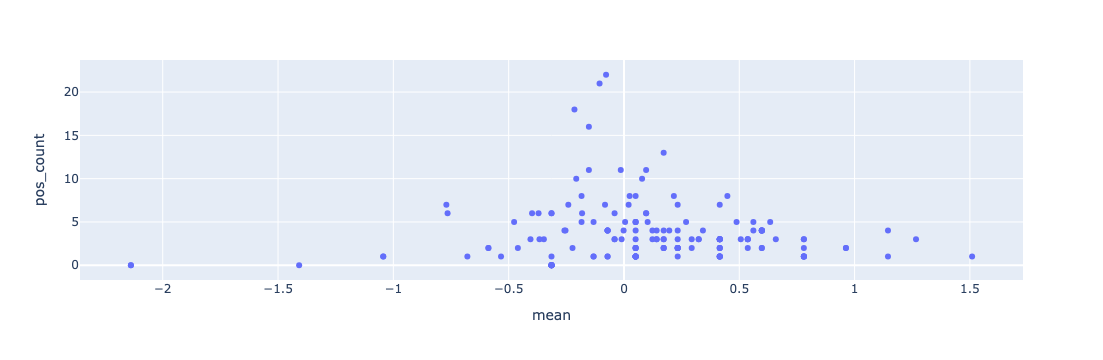

In [548]:
temp_df = grid_info_df

temp_df = temp_df.sort_values('mean', ascending = False)

temp_df

fig = px.scatter(temp_df, x = 'mean', y = 'pos_count', hover_data=['lat','lon'])

fig.show()

In [ ]:
grid_info_cost_df = grid_info(z='cost_ratio')

In [ ]:
grid_info_cost_df.sort_values('pos_count', ascending = False)

In [524]:
temp_df = df_geo[['city','lat','lon']].drop_duplicates()

x1, y1 = temp_df[temp_df['city'] == 'New Delhi'][['lat','lon']].iloc[0]
x2, y2 = temp_df[temp_df['city'] == 'Agra'][['lat','lon']].iloc[0]
x3, y3 = temp_df[temp_df['city'] == 'Jaipur'][['lat','lon']].iloc[0]

circumcenter_x, circumcenter_y = calculate_circumcenter(x1, y1, x2, y2, x3, y3)

# location filter radius in kilometers
r = 150
z = 'fee'
temp_df = temp_df.dropna()
temp_df = filter_locations(temp_df, circumcenter_x, circumcenter_y, r)

temp_df = df[df['city'].isin(temp_df['city'])]


percent = temp_df[temp_df[z] > 0].shape[0]/temp_df.shape[0]
print(f"{percent*100}% of attractions have above average fee")

above_avg = temp_df[temp_df[z] > 0].shape[0]
print(f"{above_avg} attractions have above average fee")

norm_avg = temp_df[z].mean()
print(f"The average fee is {norm_avg}")

temp_df = temp_df[temp_df[z] > 0].sort_values(z, ascending = False)


x = 'type'
y = z
filter_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    x, observed = False)[[y]].mean().sort_values(y, ascending = False).dropna()

filter = filter_df.head().index

not_top = temp_df[~temp_df['type'].isin(filter)].shape[0]
print(f"{not_top} of the above average fee are not in top 5 types")

temp_df



57.49999999999999% of attractions have above average fee
23 attractions have above average fee
The average fee is 96.125
19 of the above average fee are not in top 5 types


zone          state            city                            name  \
315   Central  Uttar Pradesh   Greater Noida     Buddh International Circuit   
302  Northern        Haryana        Gurugram               Kingdom of Dreams   
324  Northern      Rajasthan          Jaipur              Albert Hall Museum   
323  Northern      Rajasthan          Jaipur                     City Palace   
89   Northern      Rajasthan          Jaipur                      Amber Fort   
13   Northern          Delhi           Delhi       National Zoological Park    
15   Northern          Delhi           Delhi         National Science Centre   
2    Northern          Delhi           Delhi               Akshardham Temple   
181   Central  Uttar Pradesh            Agra                       Taj Mahal   
318  Northern          Delhi       New Delhi                     Rail Museum   
79   Northern      Rajasthan          Jaipur                      Hawa Mahal   
3    Northern          Delhi           Delhi            Waste to Wonder Park   
190   Central  Uttar Pradesh  Fatehpur Sikri                  Buland Darwaza   
321   Central  Uttar Pradesh            Agra                       Agra Fort   
7    Northern          Delhi           Delhi                        Red Fort   
90   Northern      Rajasthan          Jaipur                    Jaigarh Fort   
14   Northern          Delhi           Delhi                     Qutub Minar   
10   Northern          Delhi           Delhi           Garden of Five Senses   
1    Northern          Delhi           Delhi                  Humayun's Tomb   
191   Central  Uttar Pradesh           Noida            Okhla Bird Sanctuary   
12   Northern          Delhi           Delhi  National Gallery of Modern Art   
192   Central  Uttar Pradesh         Aligarh                    Aligarh Fort   
4    Northern          Delhi           Delhi                   Jantar Mantar   

               type  year  time  rating   fee airport  ... camera_num  \
315      Race Track  2011   2.0     4.6  1500     Yes  ...          1   
302   Entertainment  2010   3.0     4.4  1100     Yes  ...          1   
324          Museum  1887   2.0     4.5   200     Yes  ...          1   
323          Palace  1727   2.0     4.4   200     Yes  ...          1   
89             Fort  1592   2.0     4.6   100     Yes  ...          1   
13              Zoo  1959   3.0     4.1    80     Yes  ...          1   
15          Science  1992   5.0     4.4    70     Yes  ...          1   
2            Temple  2005   5.0     4.6    60     Yes  ...          0   
181       Mausoleum  1632   2.0     4.6    50     Yes  ...          1   
318          Museum  1977   2.0     4.4    50     Yes  ...          1   
79           Palace  1799   1.0     4.4    50     Yes  ...          1   
3        Theme Park  2019   2.0     4.1    50     Yes  ...          1   
190        Monument  1571   2.0     4.4    40     Yes  ...          1   
321            Fort  1565   2.0     4.5    40     Yes  ...          1   
7              Fort  1648   2.0     4.5    35     Yes  ...          1   
90             Fort  1726   1.5     4.5    35     Yes  ...          1   
14         Monument  1192   1.0     4.5    35     Yes  ...          1   
10             Park  2003   2.0     4.1    35     Yes  ...          1   
1              Tomb  1572   2.0     4.5    30     Yes  ...          1   
191  Bird Sanctuary  1990   1.5     4.3    30     Yes  ...          1   
12           Museum  1954   3.0     4.5    20     Yes  ...          1   
192            Fort  1524   1.0     4.1    20     Yes  ...          1   
4       Observatory  1724   2.0     4.2    15     Yes  ...          1   

    airport_num anytime  year_num                           year_group  \
315           1   False    2011.0           Independence and Partition   
302           1   False    2010.0           Independence and Partition   
324           1   False    1887.0  Late Modern and Contemporary Period   
323           1   False    1727.0      

# Plots

## Slide 3

In [ ]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

temp_df = df.loc[df[['fee']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]


sns.histplot(temp_df['fee'], fill=True, color=colors[2])

plt.title("Fee Histogram")
plt.xlabel("Fee in Rupees")
plt.show()

In [ ]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

temp_df = df.loc[df[['fee']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

temp_df = temp_df[temp_df['fee'] > 50]


sns.histplot(temp_df['fee'], fill=True, color=colors[2])

plt.title("Fee Histogram (Fee above 50 rupees)")
plt.xlabel("Fee in Rupees")
plt.show()

## Slide 4

In [ ]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')

y='fee'

temp_df = df.loc[df[['time',y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
ax = sns.boxplot(x="time", y=y, data=temp_df, color = colors[1])

plt.title("Time Required vs. Fee")
plt.xlabel("Time Required (Hrs)")
plt.ylabel("Fee (Rupees)")

plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')

y='fee'

temp_df = df.loc[df[['time',y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
ax = sns.boxplot(x="time", y=y, data=temp_df, color = colors[0])


ax.set_yscale('log')
plt.title("Time Required vs. Fee")
plt.xlabel("Time Required (Hrs)")
plt.ylabel("Fee (Rupees)")

plt.show()

## Slide 5

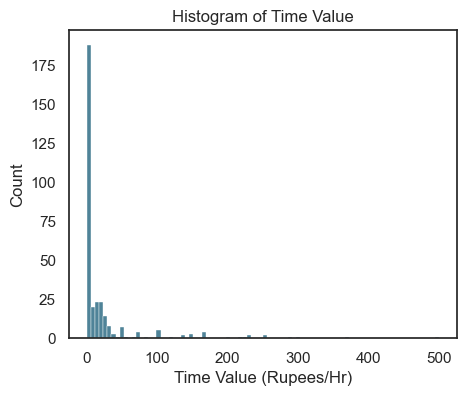

In [367]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

temp_df = df.loc[df[['cost_ratio']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]


sns.histplot(temp_df['cost_ratio'], fill=True, color=colors[3])
plt.title("Histogram of Time Value")
plt.xlabel("Time Value (Rupees/Hr)")
plt.show()

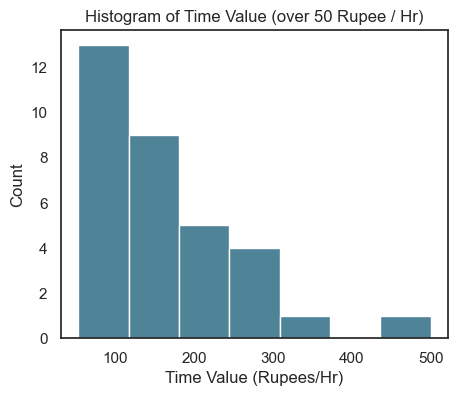

In [375]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')
plt.figure(figsize=(5, 4))

temp_df = df.loc[df[['cost_ratio']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

temp_df = temp_df[temp_df['cost_ratio'] > 50]


sns.histplot(temp_df['cost_ratio'], fill=True, color=colors[3])

plt.title("Histogram of Time Value (over 50 Rupee / Hr)")
plt.xlabel("Time Value (Rupees/Hr)")

plt.show()

## Slide 6

<Axes: xlabel='cost_ratio', ylabel='significance'>

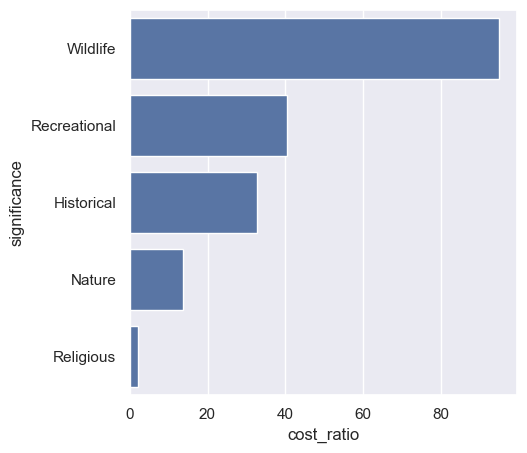

In [483]:
x = 'significance'
y = 'cost_ratio'
temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)


temp_df = df.groupby(x, observed = False).count().sort_values('rating', ascending = False)

filter = temp_df[['rating']].head().index


temp_df = df[df[x].isin(filter)]



temp_df = temp_df[[x, y]].groupby(x, observed = False).mean().sort_values('cost_ratio', ascending = False).head()

temp_df

#.mean('cost_ratio').sort_values('cost_ratio', ascending = False).head()



# temp_df = df.groupby('zone')[['cost_ratio']].mean().sort_values('cost_ratio', ascending = False)

# temp_df.reset_index(inplace = True)

# temp_df = df


plt.figure(figsize=(5, 5))
sns.set_theme(style="darkgrid")
#plt.xscale("log")
sns.barplot(y="significance", x=y, data=temp_df, orient = 'h')


<Axes: xlabel='cost_ratio', ylabel='zone'>

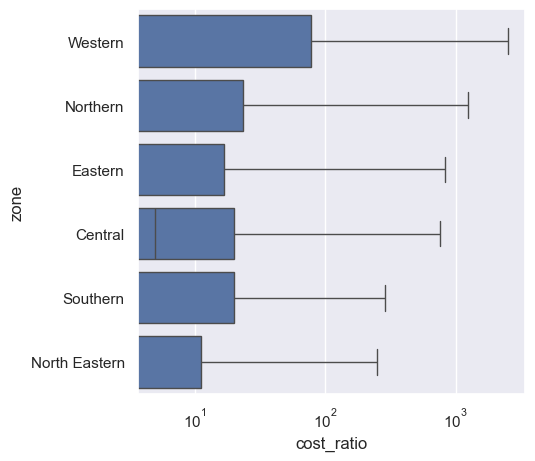

In [479]:
y = 'cost_ratio'


temp_df = df.groupby('zone')[['cost_ratio']].mean().sort_values('cost_ratio', ascending = False)

temp_df.reset_index(inplace = True)

temp_df = df.sort_values('cost_ratio', ascending = False)


plt.figure(figsize=(5, 5))
sns.set_theme(style="darkgrid")
plt.xscale("log")
sns.boxplot(y="zone", x=y, data=temp_df, orient = 'h')


## Slide 7

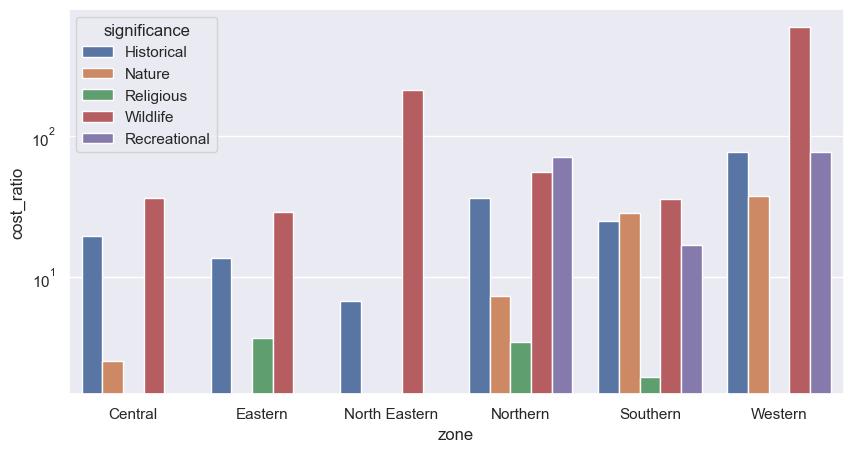

In [514]:
x= 'significance'
y = 'cost_ratio'

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3)

#temp_df = df.groupby(x, observed = False).mean(numeric_only = True).sort_values('rating', ascending = False)

temp_df = temp_df.groupby(x, observed = False).count().sort_values('rating', ascending = False)

filter = temp_df[['rating']].head().index



temp_df = df[df[x].isin(filter)]

temp_df = temp_df.groupby(['zone',x]).mean(numeric_only = True)
plt.figure(figsize=(10, 5))
sns.set_theme(style="darkgrid")
sns.barplot(x="zone", y=y, data=temp_df, errorbar=None, hue = x);
plt.yscale("log")

## Slide 7

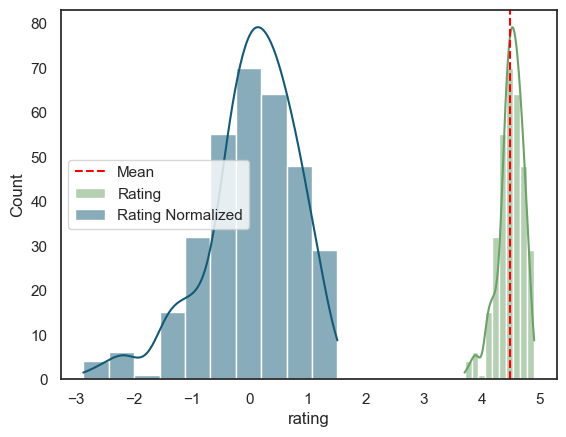

In [369]:
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus') 

temp_df = df.loc[df[['rating']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating", bins=10, kde=True, color=colors[2], label ='Rating')

temp_df = df.loc[df[['rating_norm']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating_norm", bins=10, kde=True, color=colors[3], label = 'Rating Normalized')

mean = np.mean(df['rating'])
plt.axvline(mean, color='red', linestyle='--', label='Mean')

plt.legend()
plt.show()

## Slide 7

In [ ]:
plt.figure(figsize=(5, 5))
x='year_num'
y='rating_norm'
colors = get_hex('Balistapus_undulatus')

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]

sns.regplot(
    x=x,
    y=y,
    data=temp_df
)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
x = 'year_num'
y = 'rating_norm'

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
temp_df= temp_df[temp_df['type'] == 'Lake']

sns.regplot(
    x=temp_df["year_num"],
    y=temp_df["rating_norm"],
    line_kws={"color": "red", "linewidth": 1.5},
    ax=ax,
).set(title='Type Lake')
plt.savefig("Lake.png")
plt.show()


## Slide 8

In [ ]:
sns.set(rc={'figure.figsize':(5, 5)})
sns.set_theme(style="white")
colors = get_hex('Balistapus_undulatus')


temp_df = df.loc[df[['rating_norm']].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.histplot(data=temp_df, x="rating_norm", bins=10, kde=True, hue = 'camera', palette={'Yes': colors[0], 'No': colors[4]})
plt.show()

In [ ]:
x='year_num'
y='rating_norm'
colors = get_hex('Balistapus_undulatus')

temp_df = df.loc[df[[x,y]].apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis = 1)]
sns.lmplot(
    x=x,
    y=y,
    data=temp_df,
    hue='camera', palette={'Yes': colors[0], 'No': colors[4]}
)

plt.show()

## Slide 9

In [ ]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
x = 'significance'
colors = get_hex('Balistapus_undulatus')
# load dataset

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x]).mean('rating_norm').sort_values('rating_norm', ascending = False).head(5)

# Set the figure size
plt.figure(figsize=(5, 5))

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', color = colors[3]);

In [ ]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
x = 'significance'
colors = get_hex('Balistapus_undulatus')

# load dataset

filter_df = df[df['camera'] == 'No']
temp_df = df[df['significance'].isin(filter_df['significance'].unique())]

temp_df = temp_df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x, 'camera']).mean('rating_norm').sort_values('rating_norm', ascending = False)

# Set the figure size
plt.figure(figsize=(5, 5))

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', 
            hue = 'camera', palette = {'No':colors[4], 'Yes':colors[0]});

## Slide 10

In [ ]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
colors = get_hex('Balistapus_undulatus')

x = 'type'

temp_df = df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x]).mean('rating_norm').sort_values('rating_norm', ascending = False).head(5)

# Set the figure size
plt.figure(figsize=(6, 5))

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', color = colors[3])

In [ ]:
# set plot style: grey grid in the background:
sns.set_theme(style="darkgrid")
colors = get_hex('Balistapus_undulatus')
x = 'type'
# load dataset

filter_df = df[df['camera'] == 'No']
temp_df = df[df[x].isin(filter_df[x].unique())]


temp_df1 = temp_df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x, 'camera']).mean('rating_norm')[['rating_norm']]


temp_df2 = temp_df.groupby(x, observed = False).filter(lambda x: len(x) > 3).groupby(
    [x]).mean('rating_norm').sort_values('rating_norm', ascending = False)[['rating_norm']].rename(columns={'rating_norm':'Avg'})

temp_df = temp_df1.join(temp_df2).sort_values('Avg', ascending = False)

# Set the figure size
plt.figure(figsize=(5, 5))

# grouped barplot
sns.barplot(y=x, x="rating_norm", data=temp_df, errorbar=None, orient = 'h', 
            hue = 'camera', palette = {'No':colors[4], 'Yes':colors[0]});

## Slide 11

In [ ]:
# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='rating_norm',
                        radius=10, center=dict(lat=22.5, lon=81),
                        zoom=3.8, mapbox_style="carto-positron", hover_name = 'city')

fig.update_layout(width = 800, height = 800)

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Taj Mahal')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Pangong Tso')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Rann Utsav')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False))

fig.show()

## Slide 12

In [ ]:
geolocator = Nominatim(user_agent="my_geocoder")
D_location = geolocator.geocode('New Delhi')
A_location = geolocator.geocode('Agra')
J_location = geolocator.geocode('Jaipur')

# Example usage
x1, y1 = D_location[1]
x2, y2 = A_location[1]
x3, y3 = J_location[1]

circumcenter_x, circumcenter_y = calculate_circumcenter(x1, y1, x2, y2, x3, y3)



# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='rating_norm',
                        radius=10, center=dict(lat=circumcenter_x, lon=circumcenter_y),
                        zoom=7, mapbox_style="carto-positron", hover_name = 'city')

fig.update_layout(width = 800, height = 800)

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Taj Mahal')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Pangong Tso')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Rann Utsav')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False))

lat = circumcenter_x
lon = circumcenter_y
radius = 150
# Calculate circle coordinates
num_points = 360  # Number of points for the circle
circle_lats, circle_lons = [], []
for bearing in np.arange(0, 360, 360/num_points):
    circle_lats.append(lat + radius * np.cos(np.radians(bearing)) / 111.32)
    circle_lons.append(lon + radius * np.sin(np.radians(bearing)) / (111.32 * np.cos(np.radians(lat))))

# Add circle to the map
fig.add_trace(go.Scattermapbox(
    lat=circle_lats,
    lon=circle_lons,
    mode="lines",
    line=dict(color="blue"),
    opacity=0.5,
    hoverinfo="none", showlegend = False
))

fig.show()

## Slide 13

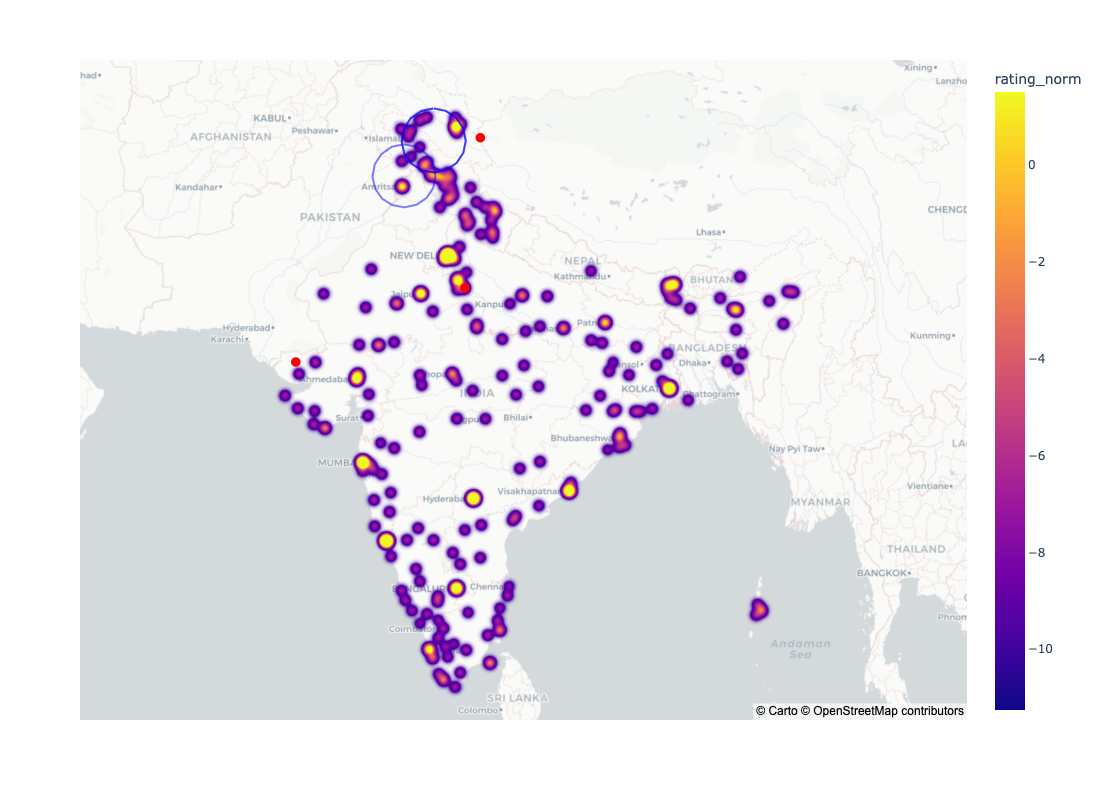

In [518]:
# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='rating_norm',
                        radius=10, center=dict(lat=22.5, lon=81),
                        zoom=3.8, mapbox_style="carto-positron", hover_name = 'city')

fig.update_layout(width = 800, height = 800)

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Taj Mahal')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Pangong Tso')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Rann Utsav')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False))


lat = 33.579252
lon = 76.4662602

radius = 150
# Calculate circle coordinates
num_points = 360  # Number of points for the circle
circle_lats, circle_lons = [], []
for bearing in np.arange(0, 360, 360/num_points):
    circle_lats.append(lat + radius * np.cos(np.radians(bearing)) / 111.32)
    circle_lons.append(lon + radius * np.sin(np.radians(bearing)) / (111.32 * np.cos(np.radians(lat))))

# Add circle to the map
fig.add_trace(go.Scattermapbox(
    lat=circle_lats,
    lon=circle_lons,
    mode="lines",
    line=dict(color="blue"),
    opacity=0.5,
    hoverinfo="none", showlegend = False
))

lat = 33.579252
lon = 76.4662602

radius = 150
# Calculate circle coordinates
num_points = 360  # Number of points for the circle
circle_lats, circle_lons = [], []
for bearing in np.arange(0, 360, 360/num_points):
    circle_lats.append(lat + radius * np.cos(np.radians(bearing)) / 111.32)
    circle_lons.append(lon + radius * np.sin(np.radians(bearing)) / (111.32 * np.cos(np.radians(lat))))

# Add circle to the map
fig.add_trace(go.Scattermapbox(
    lat=circle_lats,
    lon=circle_lons,
    mode="lines",
    line=dict(color="blue"),
    opacity=0.5,
    hoverinfo="none", showlegend = False
))

lat = 32.079252
lon = 74.9662602

radius = 150
# Calculate circle coordinates
num_points = 360  # Number of points for the circle
circle_lats, circle_lons = [], []
for bearing in np.arange(0, 360, 360/num_points):
    circle_lats.append(lat + radius * np.cos(np.radians(bearing)) / 111.32)
    circle_lons.append(lon + radius * np.sin(np.radians(bearing)) / (111.32 * np.cos(np.radians(lat))))

# Add circle to the map
fig.add_trace(go.Scattermapbox(
    lat=circle_lats,
    lon=circle_lons,
    mode="lines",
    line=dict(color="blue"),
    opacity=0.5,
    hoverinfo="none", showlegend = False
))


fig.show()

In [526]:
sns.scatterplot(x=temp_df['mean'], y=temp_df['pos count'])
plt.show()

KeyError: 'mean'

## Slide 15

## Slide 14

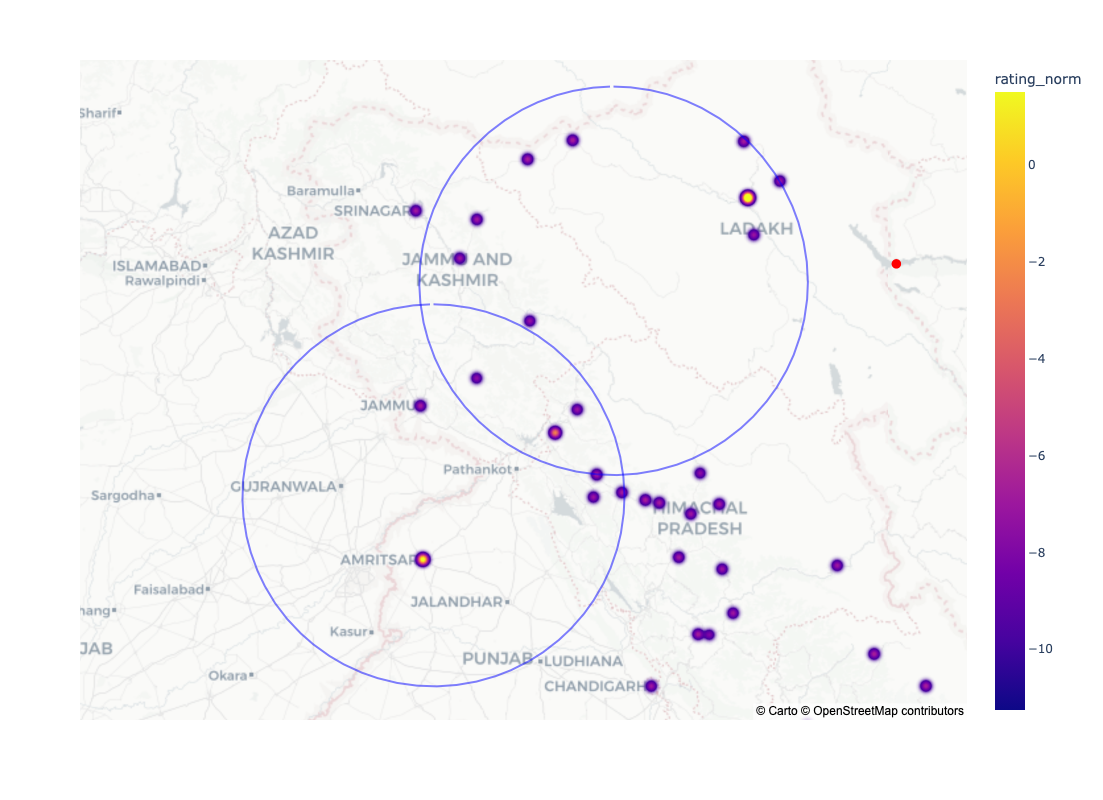

In [516]:
# Create the heatmap
lat1 = 33.579252
lon1 = 76.4662602

lat2 = 32.079252
lon2 = 74.9662602

lat = (lat1 + lat2)/2
lon = (lon1 + lon2)/2

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='rating_norm',
                        radius=10, center=dict(lat=lat, lon=lon),
                        zoom=6.4, mapbox_style="carto-positron", hover_name = 'city')

fig.update_layout(width = 800, height = 800)

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Taj Mahal')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Pangong Tso')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Rann Utsav')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False))

lat = lat1
lon = lon1
radius = 150
# Calculate circle coordinates
num_points = 360  # Number of points for the circle
circle_lats, circle_lons = [], []
for bearing in np.arange(0, 360, 360/num_points):
    circle_lats.append(lat + radius * np.cos(np.radians(bearing)) / 111.32)
    circle_lons.append(lon + radius * np.sin(np.radians(bearing)) / (111.32 * np.cos(np.radians(lat))))

# Add circle to the map
fig.add_trace(go.Scattermapbox(
    lat=circle_lats,
    lon=circle_lons,
    mode="lines",
    line=dict(color="blue"),
    opacity=0.5,
    hoverinfo="none", showlegend = False
))

lat = lat2
lon = lon2
radius = 150
# Calculate circle coordinates
num_points = 360  # Number of points for the circle
circle_lats, circle_lons = [], []
for bearing in np.arange(0, 360, 360/num_points):
    circle_lats.append(lat + radius * np.cos(np.radians(bearing)) / 111.32)
    circle_lons.append(lon + radius * np.sin(np.radians(bearing)) / (111.32 * np.cos(np.radians(lat))))

# Add circle to the map
fig.add_trace(go.Scattermapbox(
    lat=circle_lats,
    lon=circle_lons,
    mode="lines",
    line=dict(color="blue"),
    opacity=0.5,
    hoverinfo="none", showlegend = False
))

fig.show()

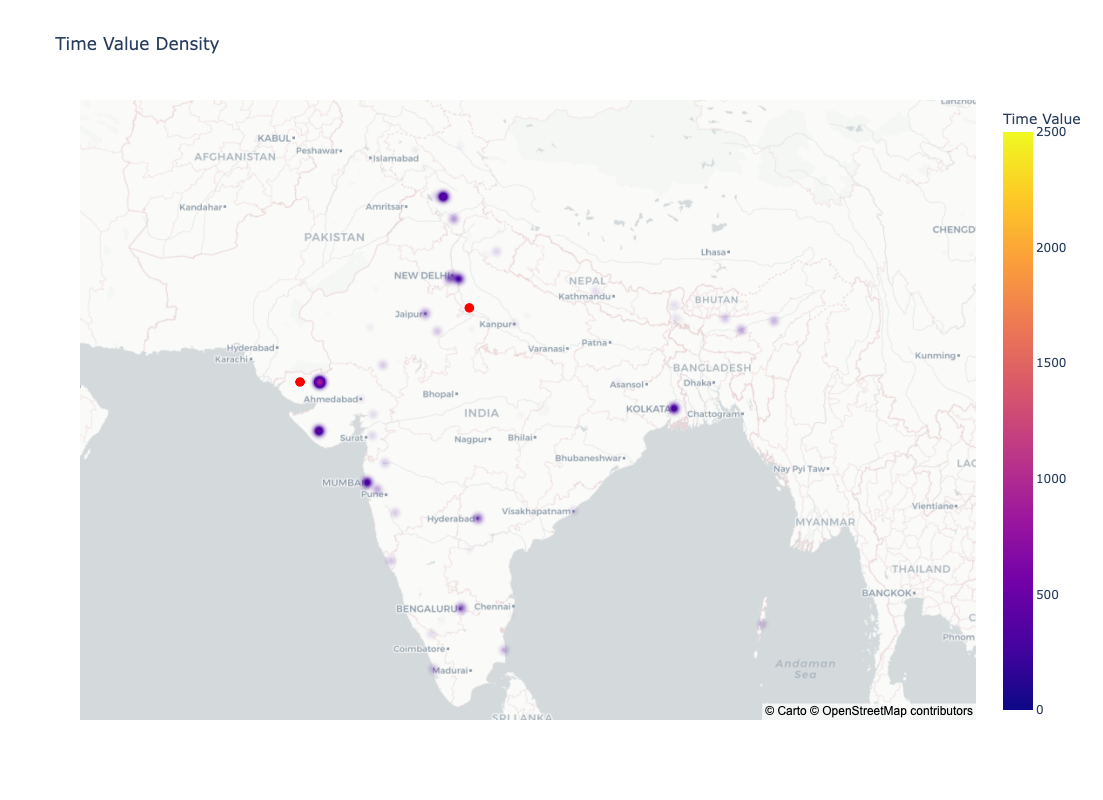

In [80]:
# Create the heatmap
temp_df = df_geo

temp_df = temp_df.rename(columns={'cost_ratio':'Time Value'})

fig = px.density_mapbox(temp_df, lat='lat', lon='lon', z='Time Value',
                        radius=10, center=dict(lat=22.5, lon=81),
                        zoom=3.8, mapbox_style="carto-positron", hover_name = 'city', title = 'Time Value Density')

fig.update_layout(width = 800, height = 800)

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Taj Mahal')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Rann Utsav')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False))

#fig.write_image("fee.png", scale=5) 

fig.show()

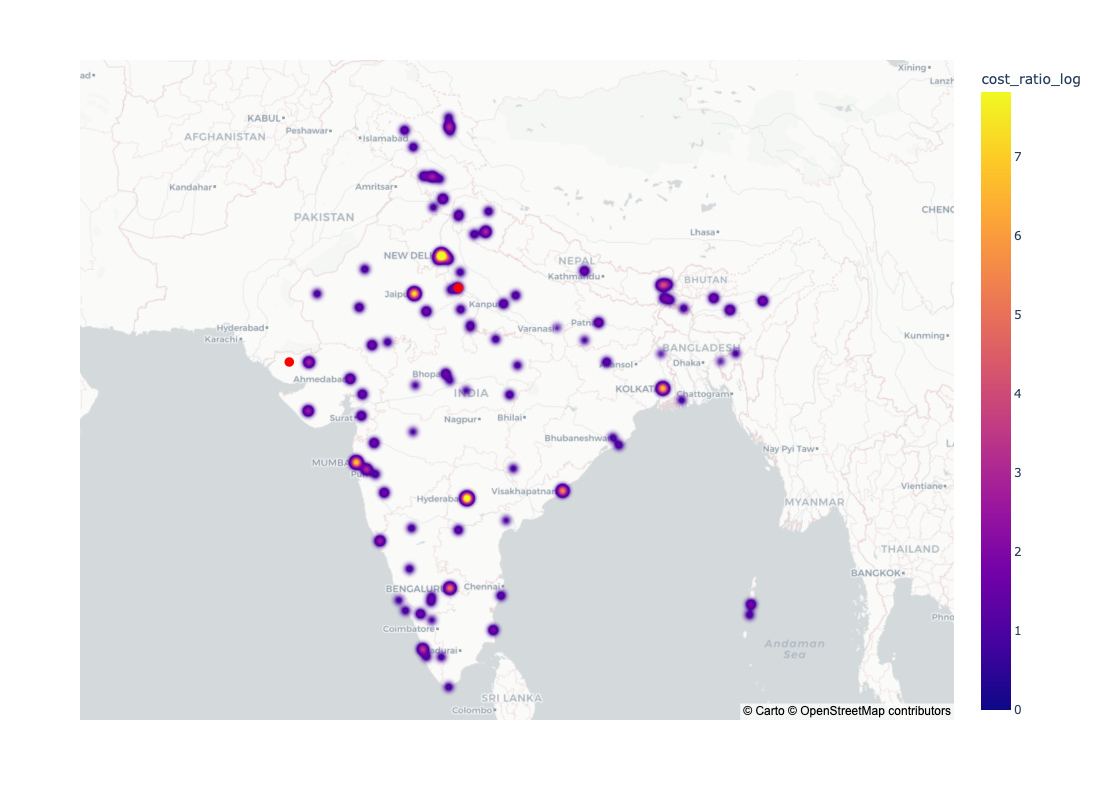

In [2961]:
# Create the heatmap

fig = px.density_mapbox(df_geo, lat='lat', lon='lon', z='cost_ratio_log',
                        radius=10, center=dict(lat=22.5, lon=81),
                        zoom=3.8, mapbox_style="carto-positron", hover_name = 'city')

fig.update_layout(width = 800, height = 800)

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Taj Mahal')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False
))

geolocator = Nominatim(user_agent="my_geocoder")
location = geolocator.geocode('Rann Utsav')

fig.add_trace(go.Scattermapbox(
lat=[location.latitude], lon=[location.longitude],
mode="markers+text",
marker=dict(size=10, color="red"),
textposition="bottom center", showlegend = False))

fig.show()

## Slide 16